In [1]:
import torch
import torch.nn as nn

import math
from collections import OrderedDict
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
def str2act(txt, param= None):
    return {"sigmoid": nn.Sigmoid(), "relu": nn.ReLU(), "none": nn.Sequential() , "lrelu": nn.LeakyReLU(param), "selu": nn.SELU() }[txt.lower()]

import copy

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
   
    def forward(self, x):
        return x.view(x.shape[0],-1) 

def init_layer(op):
    stdv = 1. / math.sqrt(op.weight.size(1)) 
    op.weight.data.uniform_(-stdv, stdv) 
    if op.bias is not None: 
        op.bias.data.fill_(0.0)

device = torch.device("cuda:2")



In [2]:
class Grad():
    def __init__(self, model, grad = False):
        self.grads = []
        self.model = model
        for linop in model.linops:
            if grad:
                self.grads.append(linop.weight.grad.clone())
            else:
                self.grads.append(torch.zeros_like(linop.weight))


    
    def __len__(self):
        return len(self.grads)

    def __getitem__(self, key):
        return self.grads[key]

    def update(self, key,value):
        self.grads[key] = value
    
    def zero(self):
        for grad in self.grads:
            grad.zero_()

    def __iadd__(self, other):
        for i in range(len(self)):
            self.grads[i] = self[i] + other[i]
        return self
    
    def __itruediv__(self, other):
        for i in range(len(self)):
            self.grads[i] = self[i] / other
        return self
    
#     def normalize(self):    
#         for i in range(len(self)):
#             self.grads[i] = self[i] / self[i].norm()
#         return self
    
    def normalize(self):
        out = Grad(self.model)
        for i in range(len(self)):
            out.grads[i].data = self[i] / self[i].norm()
            
        return out
    
    def __sub__(self, other):
        S = 0
        for i in range(len(self)):
            S = ((self[i] - other[i])**2).sum()
        return S
    
    def diff(self, other):
        cosines = np.zeros([len(self)])
        for i in range(len(self)):
            S = (self[i] * other[i]).sum()/ (self[i].norm() * other[i].norm())
            cosines[i] = S
        return cosines
    
    def angle(self, other):
        cosines = self.diff(other)
            
        return [np.arccos(c)*(180/np.pi) for c in cosines]
    
    
    def __truediv__(self, other):
        out = Grad(self.model)
        out.model = self.model
        for i in range(len(self)):
            out[i].data = self[i].data/other
            
        return out

In [3]:
class PlainFC(nn.Module):
    def __init__(self, input_size, layers, act, widening, lamb = 0.0, classes= 10, first_layer = None):
        super(PlainFC,self).__init__()

        self.actstr = act


        self.input_size  = input_size
        self.layers  = layers
        self.lamb = lamb


        if first_layer is None:
            layer_specs = [ (input_size*input_size)*widening**i for i in range(layers+1)]
        else:
            layer_specs = [ (input_size*input_size)] + [first_layer*widening**(i) for i in range(layers)]

        layer_specs = layer_specs[0:self.layers+1]

        self.linops = nn.ModuleList()

        ##op, pad = self._gen_conv(layer_specs[0] ,layer_specs[1], convGlu = self.convGlu, rounding_needed  = True)
        ##op = nn.Sequential(pad, conv)

        last_ch = layer_specs[0]
        self.act = str2act(self.actstr,self.lamb)

        self.num_neurons = np.sum(layer_specs[1:]) + classes

        if layers > 0:
            op = nn.Linear(last_ch, layer_specs[1], bias = False)
            init_layer(op)
            self.linops.append(op)
            last_ch = layer_specs[1]

        for i,ch_out in enumerate(layer_specs[2:]):

            linop = nn.Linear(last_ch, ch_out, bias = False)
            init_layer(linop)
            print("last_ch: %d, ch_out: %d " %(last_ch, ch_out))

            self.linops.append(linop)
            last_ch = ch_out

        print("last_ch: %d, ch_out: %d " %(last_ch, classes))
        linop = nn.Linear(last_ch, classes, bias = False)
        self.linops.append(linop)
        print(self)
        self.distinct_mapping = None


    def forward(self, x, layers = None):
        

        src_shape = x.shape
        x = x.view(src_shape[0],-1) 

        for i,linop in enumerate(self.linops):
            
            if not layers is None and layers == i:
                return x
            
            x = linop(x)
            
            if i < len(self.linops) - 1:
                x = self.act(x)
            

        return x


    def mage_fb(self, X, g0, b, dLdout, Js, Vs, Us, Qs, As, Abars, transform = False):
        
        V = Grad(self)
        grad = Grad(self)
        old_grad = None
        L = len(model.linops)
        for m in range(L):
            
            linop = model.linops[m]
            #vw = b[m]*torch.matmul(Abars[m].unsqueeze(2) ,Jop(Js,m+1,g0).unsqueeze(1))       ##    B x d_m   1 x d_m+1 -> B x d_m+1
            vw = b[m]*torch.matmul(Abars[m].unsqueeze(2) ,Jop(Js,m+1,g0).unsqueeze(1)).permute(0,2,1)       ## 
            ##import pdb; pdb.set_trace()
            new_grad = torch.matmul(vw, Abars[m].unsqueeze(2)).squeeze()    ## B x N1

            V.update(m,vw.clone())
    
            if not old_grad is None:
                old_grad = torch.matmul(old_grad, linop.weight.permute(1,0)) ## B X N0  mm  N0 X N1 -> B X N1
            else:
                old_grad = 0
            old_grad = old_grad + new_grad
            
        dFg = (dLdout*old_grad).sum(1, keepdim = True)
            
        for i in range(L):

            linop = self.linops[i]
            
            vw = V[i]
            # print(vw.shape)
            # print(self.linops[i].weight.shape)

            
            if vw.shape[0] == 1:
                G = dFg.squeeze() * vw.squeeze(0)
            else:
                G = torch.matmul(dFg.permute(1,0), vw.reshape(vw.shape[0],-1)).view(vw.shape[1],vw.shape[2])

            if transform:
                G = Us[i+1].mm(G)
            grad.update(i,G.clone())    ## 1 x B   mm   Bx(N1xN2)  >   N1 x N2
        
        return grad

    def backward(self, dLDout, As):
        
        grad = Grad(self)
        batch_size = As[0].size(0)
        neural_grad = dLDout
        L = len(model.linops)
        for m in range(L-1,-1,-1):
            
            
            linop = model.linops[m]
            W = linop.weight
            
            grad.update(m,torch.matmul(neural_grad.t(),As[m]).clone())
            neural_grad = neural_grad.mm(W)
        
        return grad

    
    
    
    def zero_grad(self):
        for linop in self.linops:
            linop.weight.grad = None

In [4]:
model = PlainFC(input_size=2, layers=2, act="none", widening=1, lamb = 0.0, classes= 4, first_layer = None)

model = model.cuda(device = device)


last_ch: 4, ch_out: 4 
last_ch: 4, ch_out: 4 
PlainFC(
  (linops): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=False)
    (1): Linear(in_features=4, out_features=4, bias=False)
    (2): Linear(in_features=4, out_features=4, bias=False)
  )
  (act): Sequential()
)


In [5]:
def calc_Js(model, device):
    
    
    Js = []
    input_size = model.input_size
    J = torch.eye(input_size**2, device = device) ##J0
    Js.append(J.clone())
    for linop in model.linops:
        J = torch.inverse(linop.weight.t()).mm(J)
        Js.append(J.clone())

    return Js

def calc_As(model, device,x):
    As = []
    for i in range(model.layers+1):
        As.append(model(x,i).clone())
    return As

def calc_Abars(As):
    Abars = []
    for A in As:
        Abars.append((A/A.norm(dim=1, keepdim = True)).clone())
    return Abars

def calc_Vs(Js):
    Vs = []
    
    for J in Js:
        Vs.append(J.mm(J.t()).clone())
        ##Vs.append(J.t().mm(J).clone())

    return Vs

def calc_Us(Vs):
    Us = []
    
    for V in Vs:
        Us.append(torch.inverse(V).clone())

    return Us

def calc_Qs(Js):
    L = len(Js)
    Qs = [[Js[i].mm(Js[j].t()).clone() for j in range(L)] for i in range(L)]         
    return Qs

def calc_all(model,device, X = None):
    
    Js = calc_Js(model,device)
    Vs = calc_Vs(Js)
    Us = calc_Us(Vs)
    Qs = calc_Qs(Js)
    if X is None:
        return Js, Vs, Us, Qs
    As = calc_As(model, device,X)
    Abars = calc_Abars(As)
    return Js, Vs, Us, Qs, As, Abars

def Jop(Js, layer , g):
    return Js[layer].mm(g.permute(1,0)).permute(1,0)

def Aop(model, Js, layer , g, x):
    g_n = Jop(Js, layer , g)
    a = model( x  ,layer-1)
    return g_n.view(-1,1).mm(a.view(1,-1))

In [6]:

    
def Sanity_TestJ(model, error = 1e-4):
    model.zero_grad()
    Js = calc_Js(model,device)
    x = Variable(torch.torch.randn([1,4],device = device), requires_grad = True)
    x.grad = None
    y = model(x)
    loss = ((y-1)**2).sum().sqrt()
    loss.backward()
    g0 = x.grad

    flag = True
    for i in range(1,len(model.linops)):
        g = Jop(Js,i,g0).view(-1,1)
        ga = Aop(model,Js,i,g0,x)
        
        
        if ((ga - model.linops[i-1].weight.grad)**2).sum() > error:
            print("Mismatch at %d:" % i)
            print(ga)
            print(model.linops[i-1].weight.grad)
            flag = False
            
    if flag:
        print("Test Passed")
    model.zero_grad()

Sanity_TestJ(model)

Test Passed


real vs bwd
[0.00034527        nan 0.        ]


/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arccos


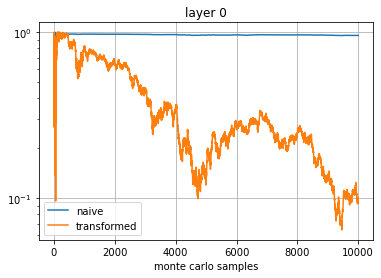

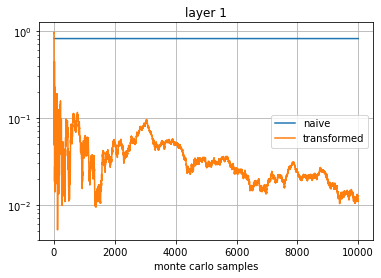

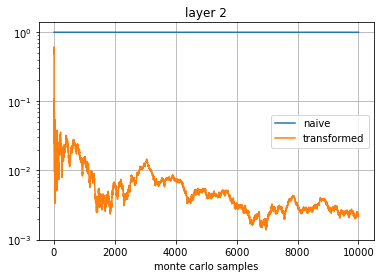

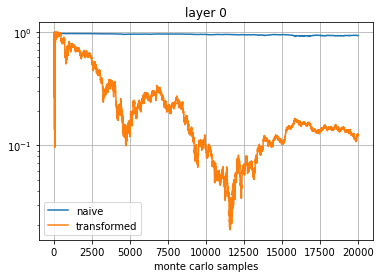

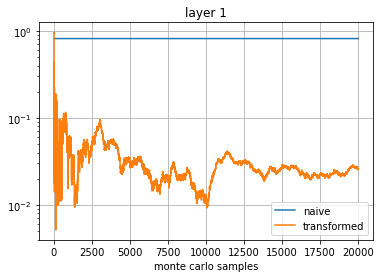

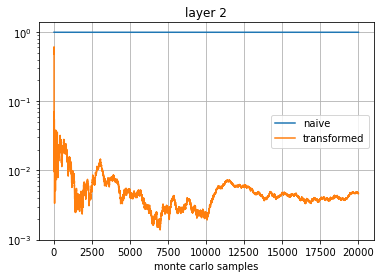

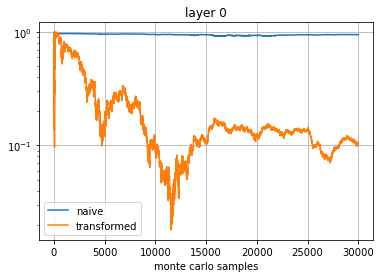

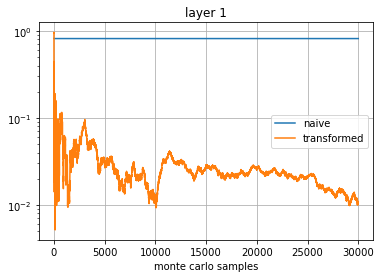

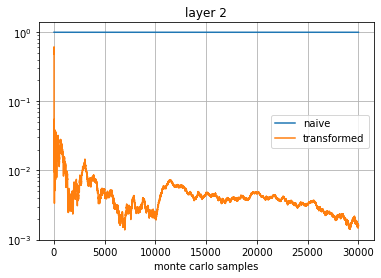

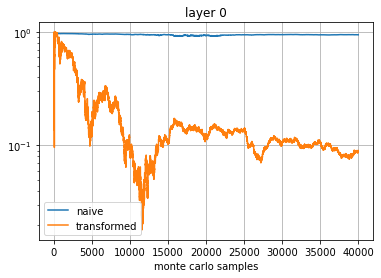

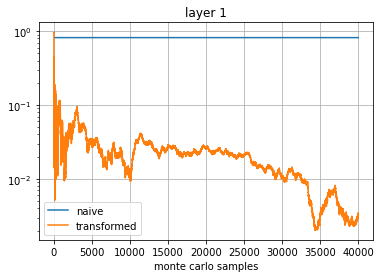

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


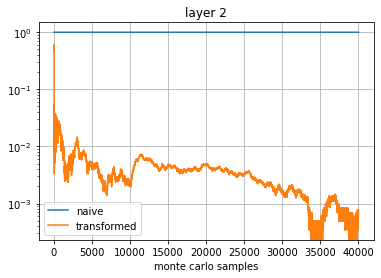

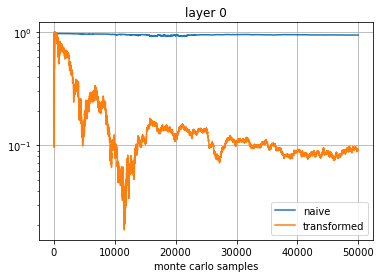

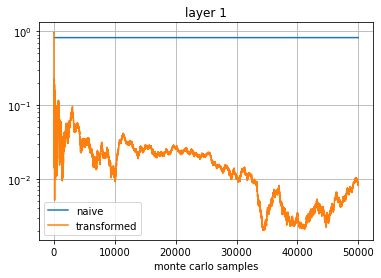

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


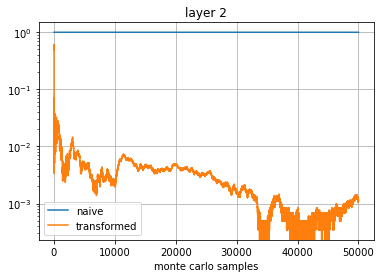

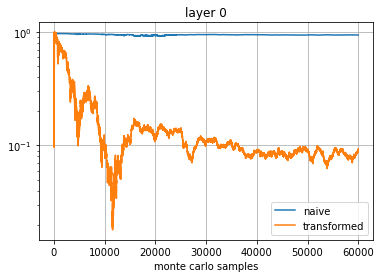

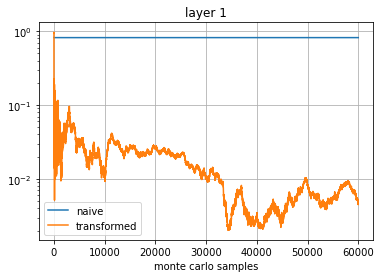

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


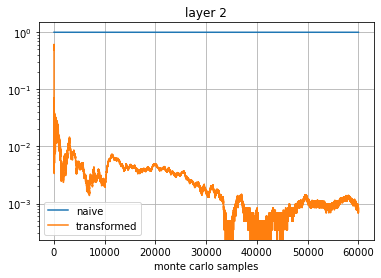

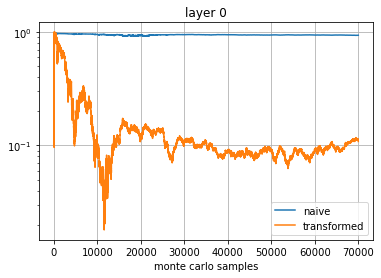

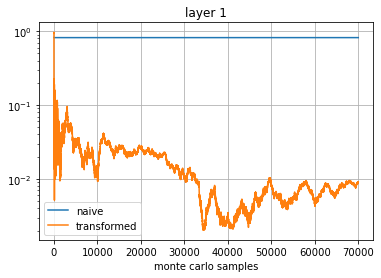

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


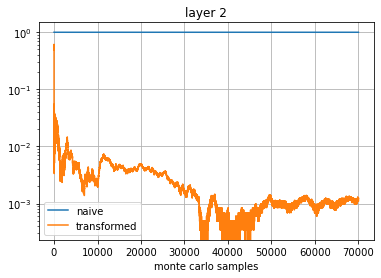

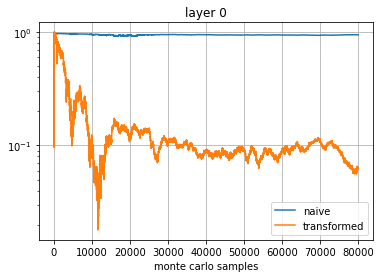

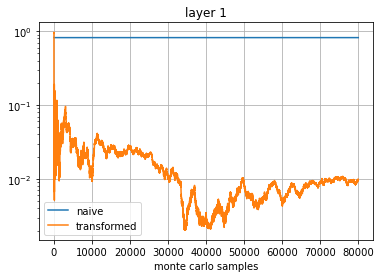

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


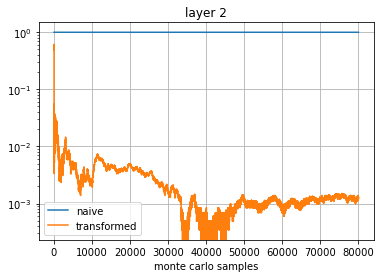

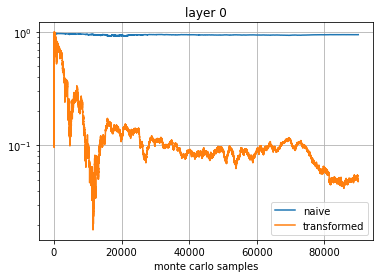

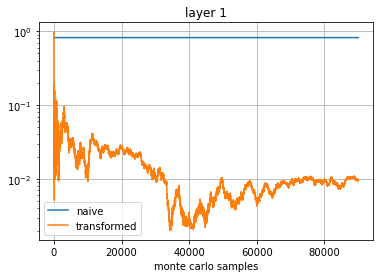

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


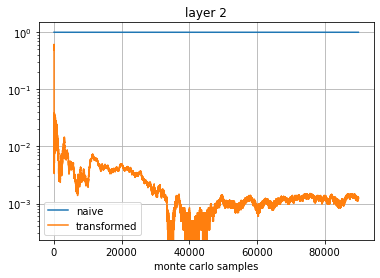

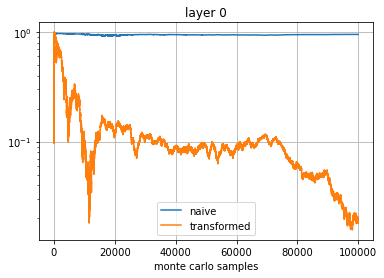

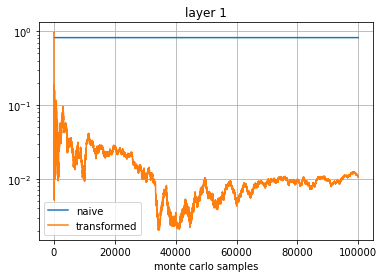

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


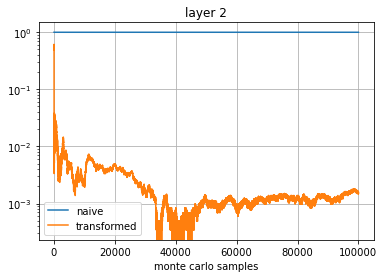

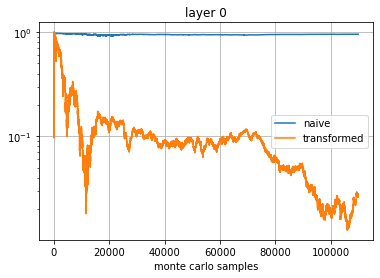

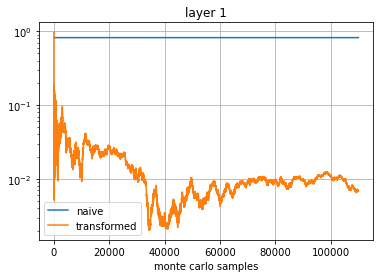

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


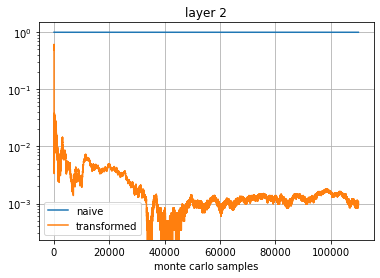

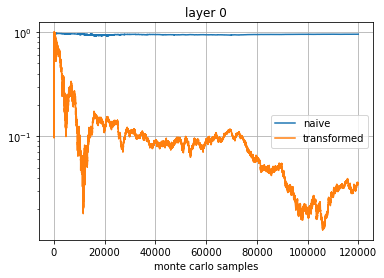

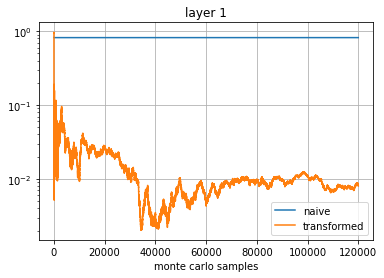

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


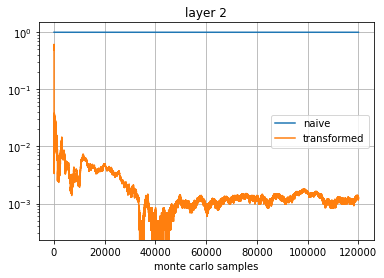

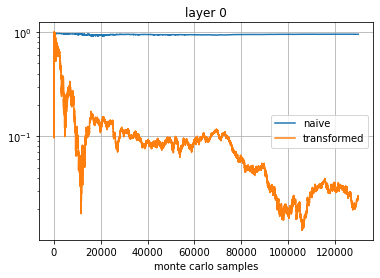

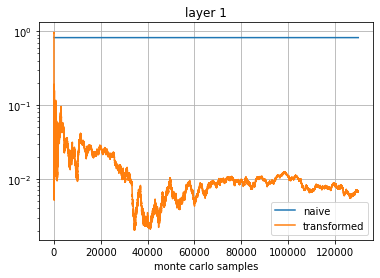

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


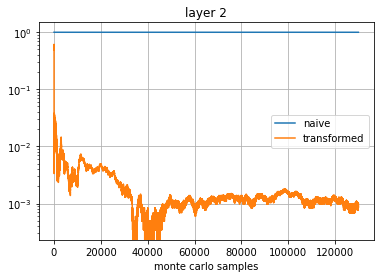

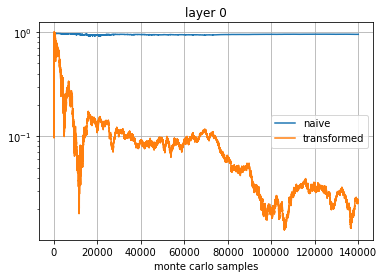

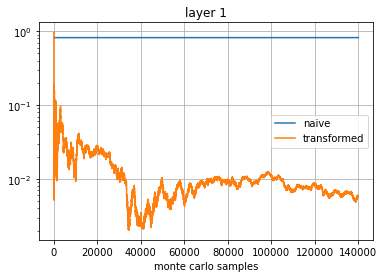

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


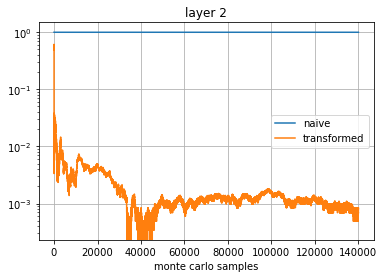

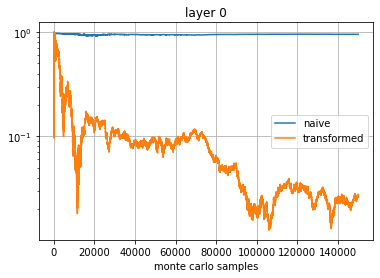

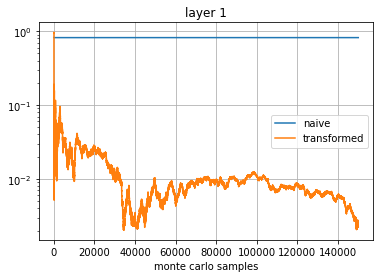

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


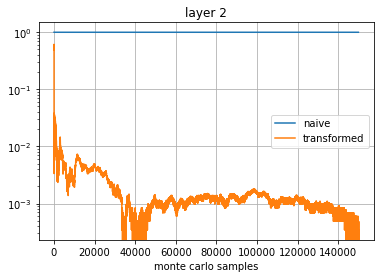

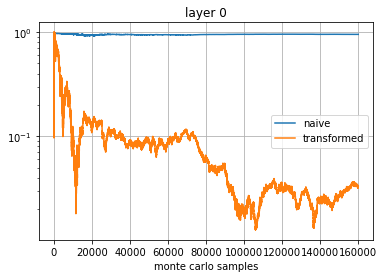

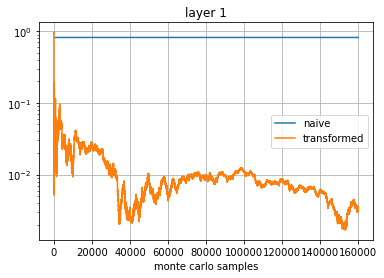

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


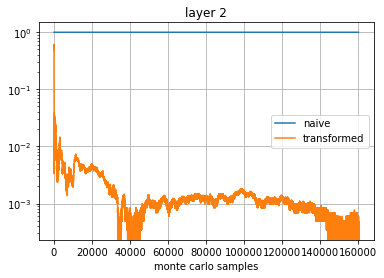

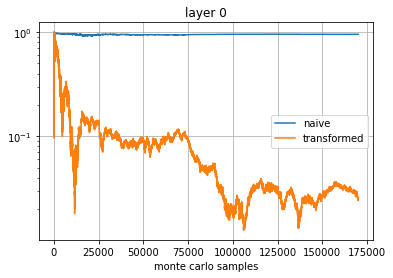

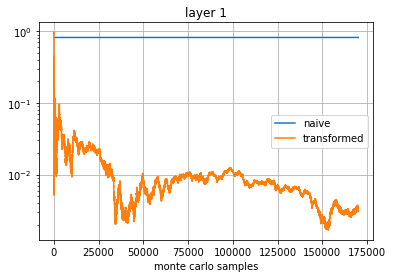

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


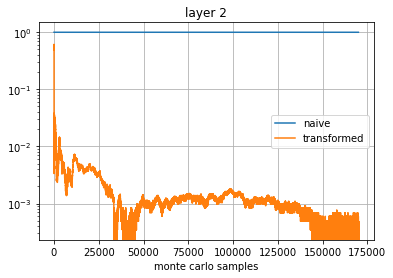

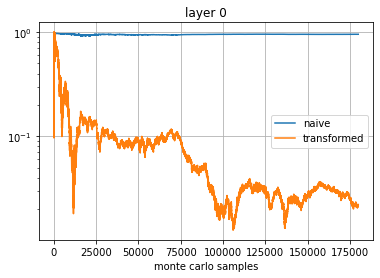

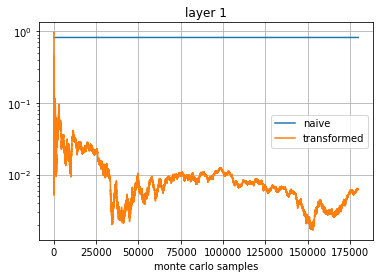

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


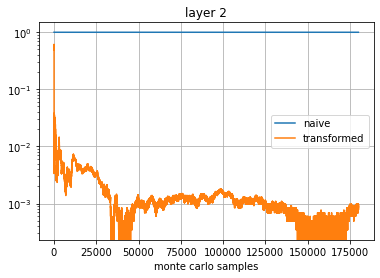

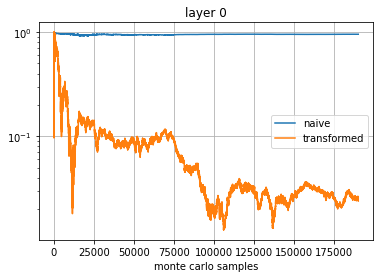

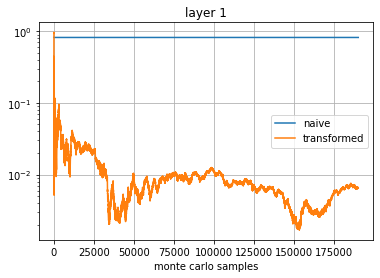

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


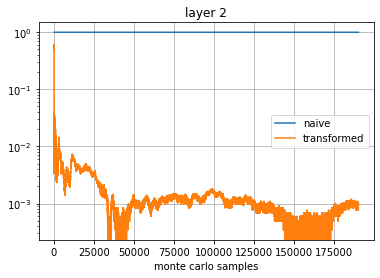

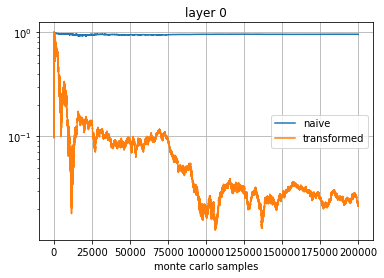

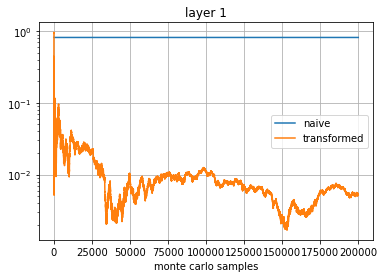

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


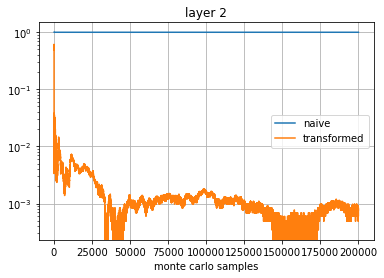

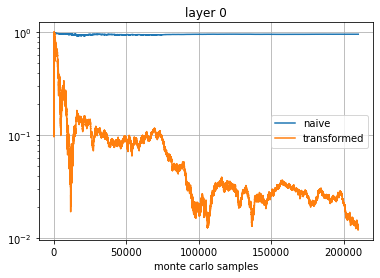

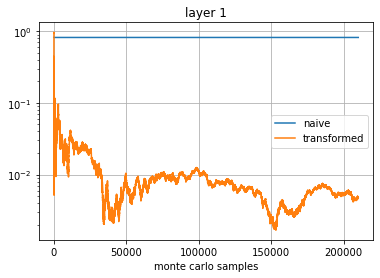

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


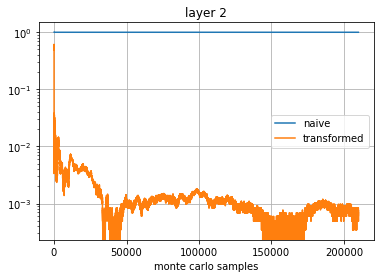

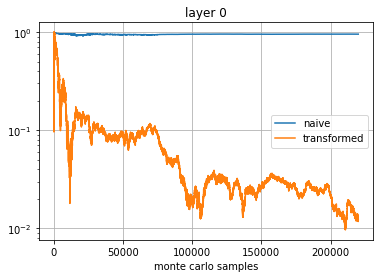

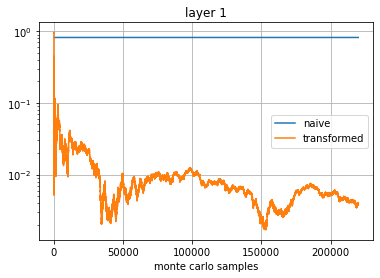

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


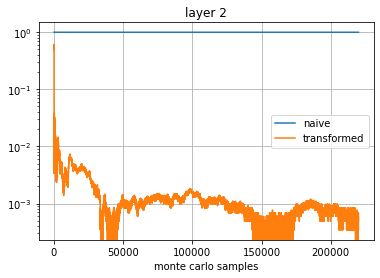

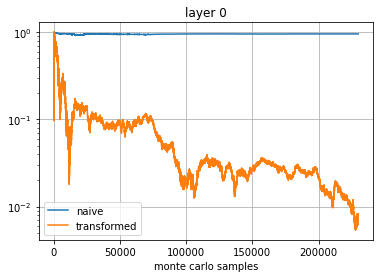

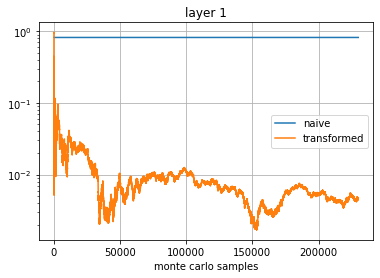

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


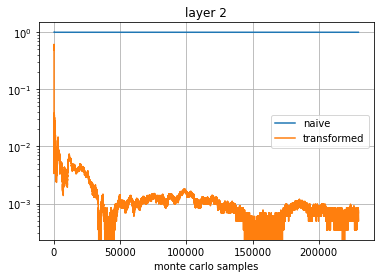

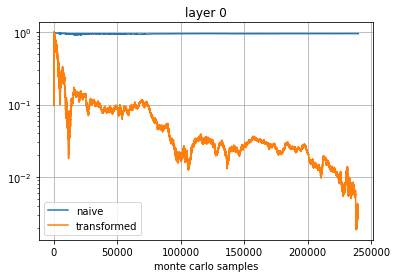

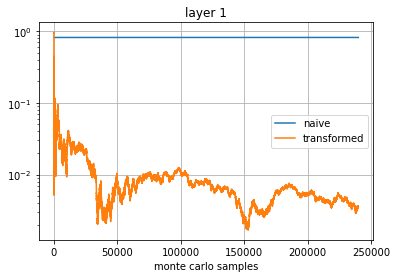

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


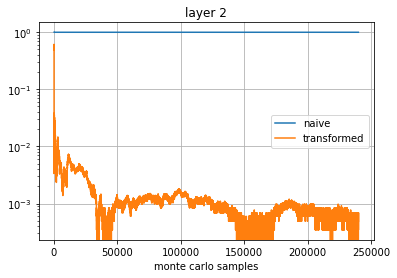

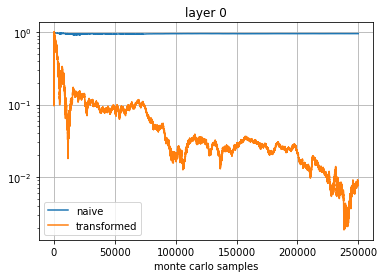

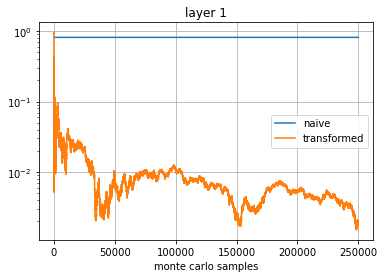

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


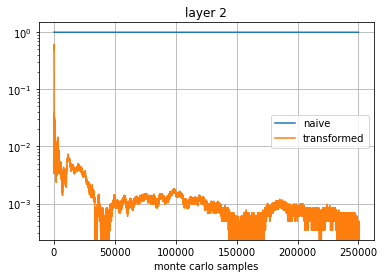

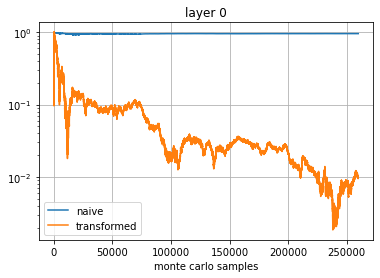

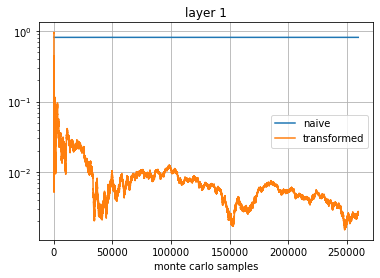

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


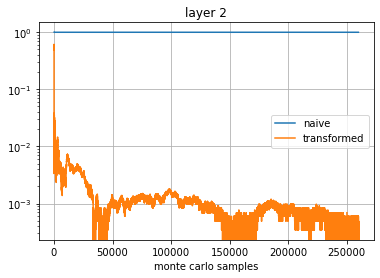

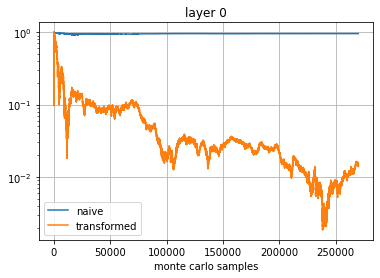

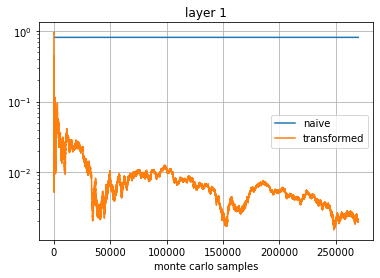

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


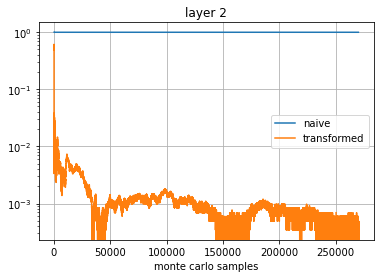

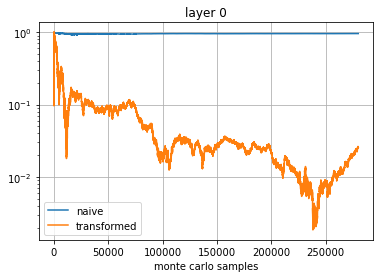

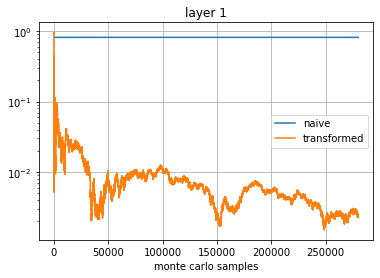

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


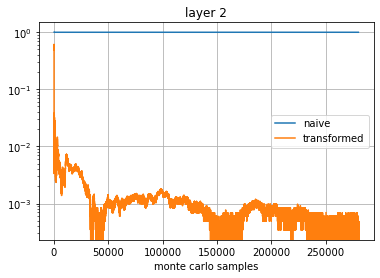

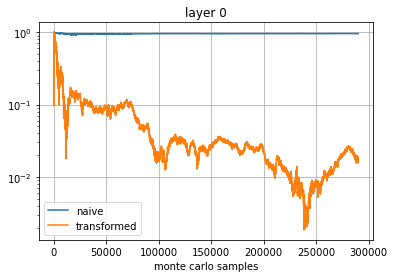

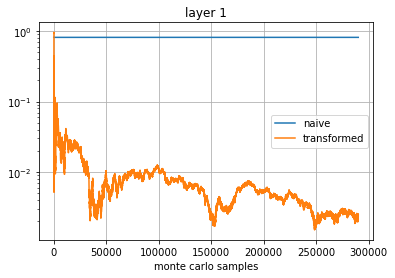

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


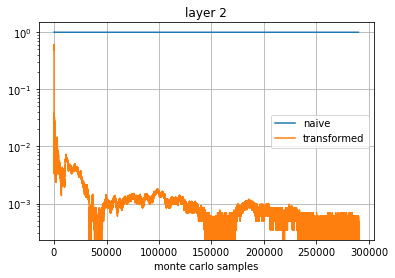

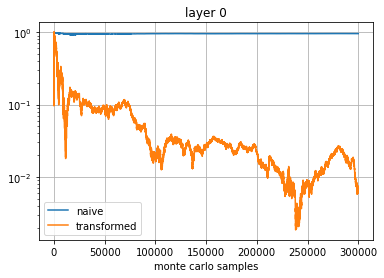

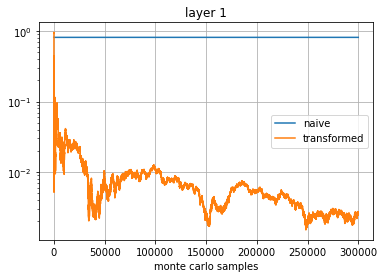

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


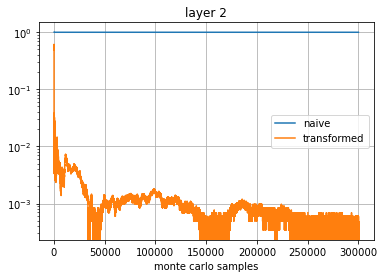

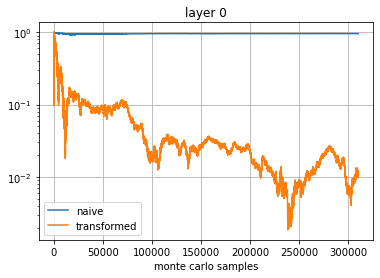

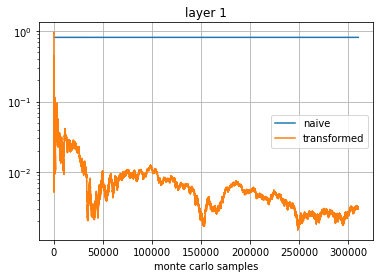

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


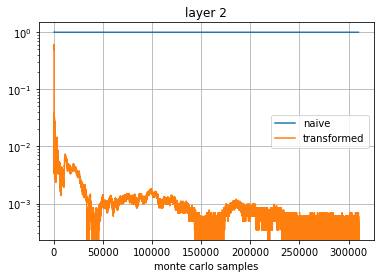

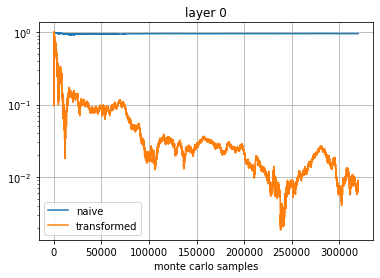

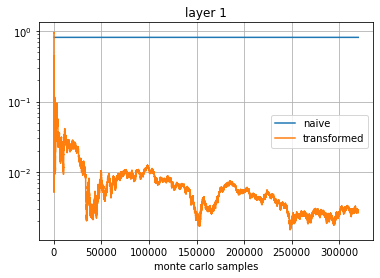

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


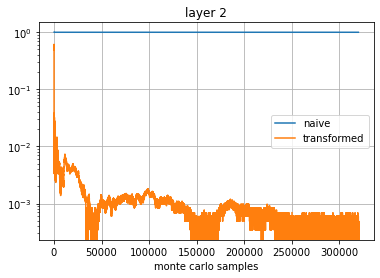

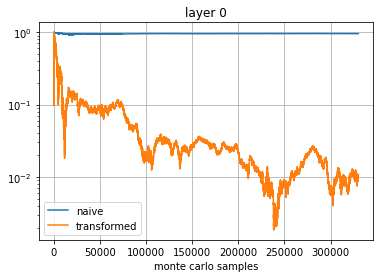

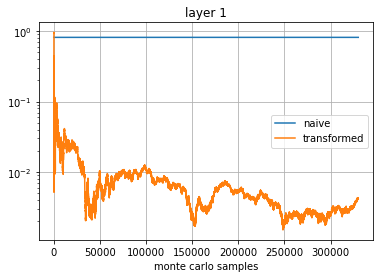

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


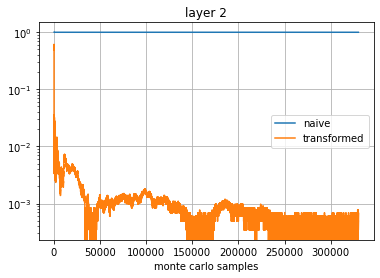

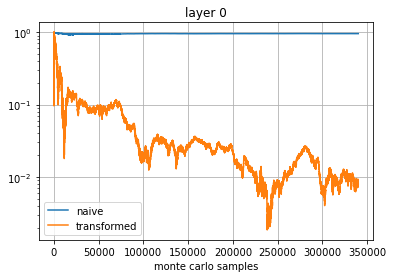

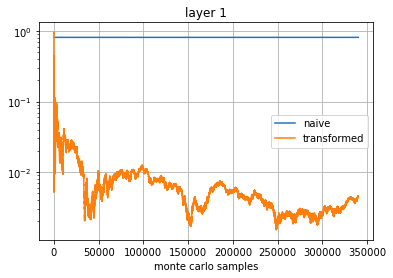

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


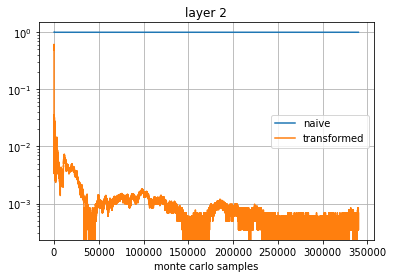

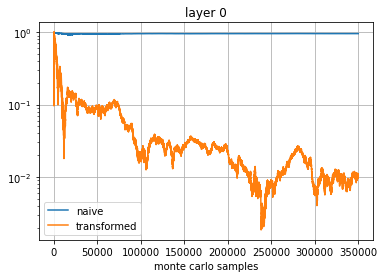

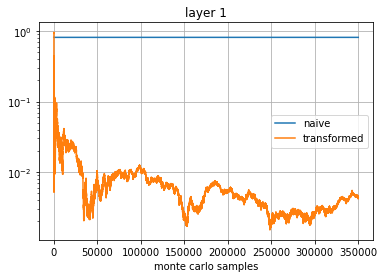

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


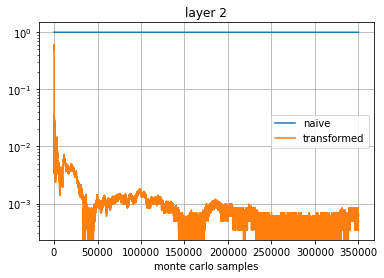

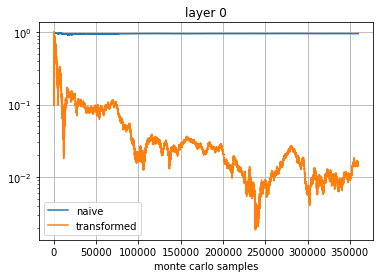

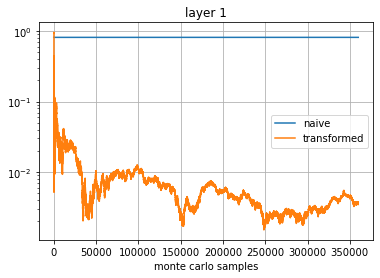

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


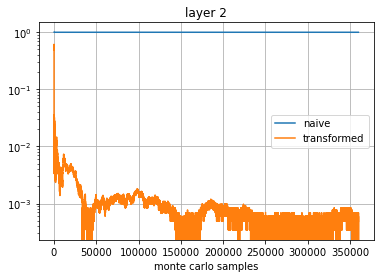

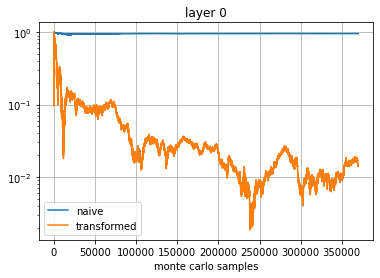

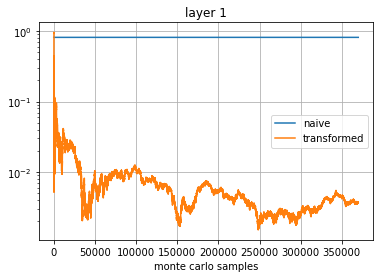

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


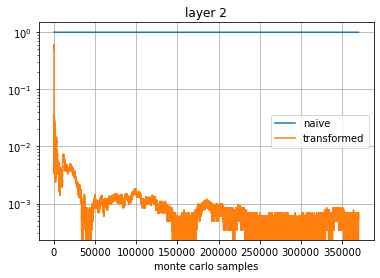

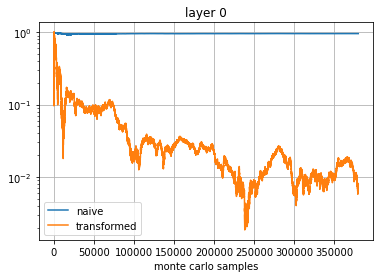

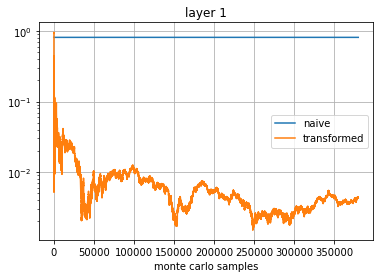

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


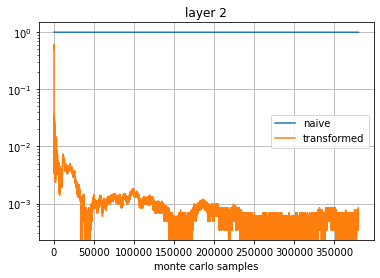

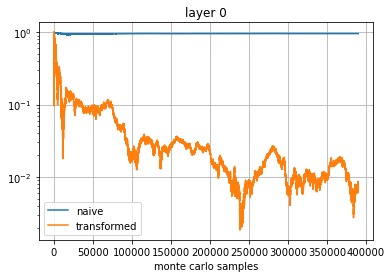

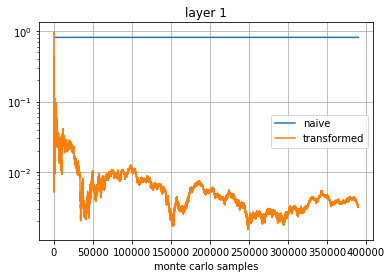

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


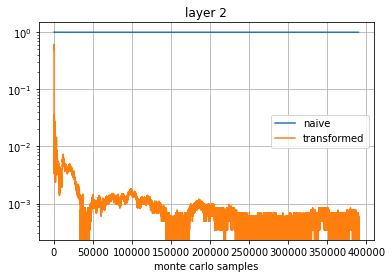

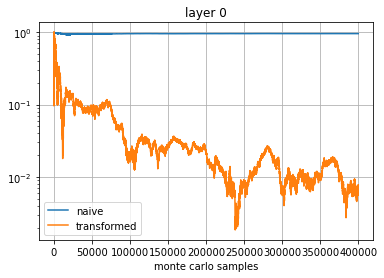

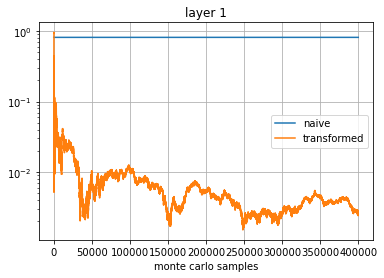

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


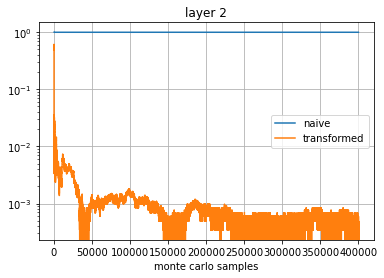

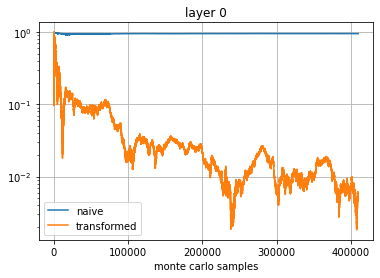

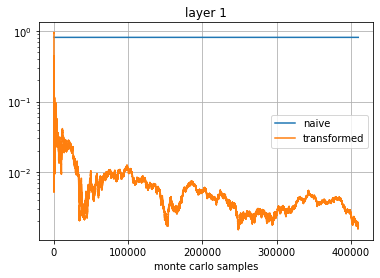

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


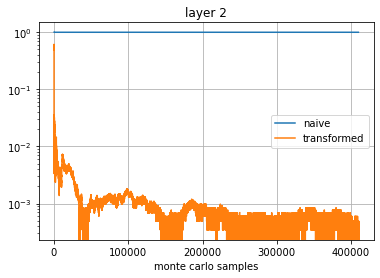

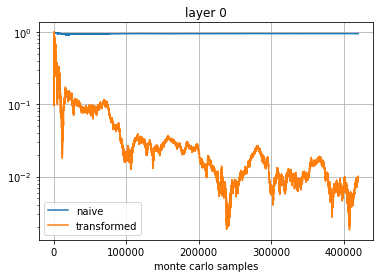

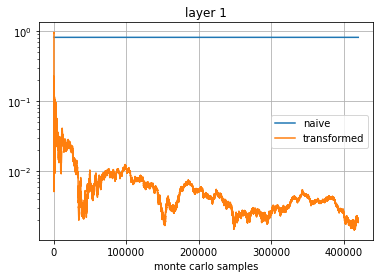

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


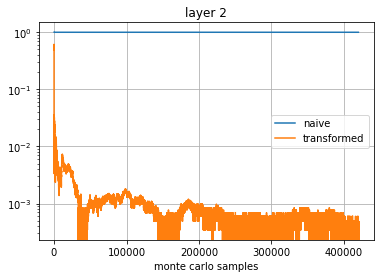

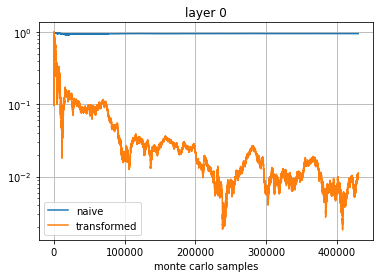

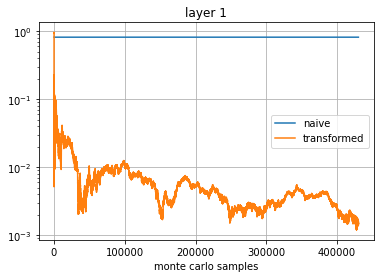

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


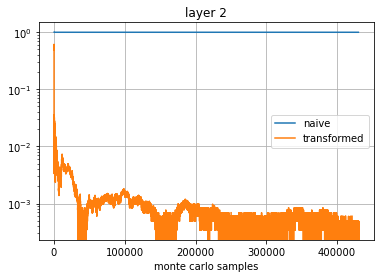

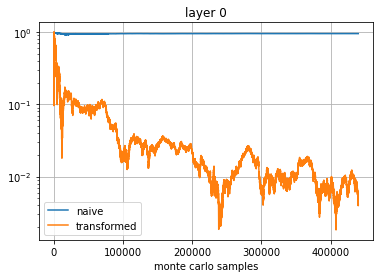

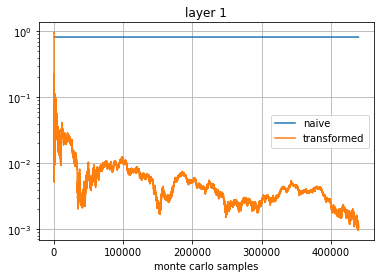

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


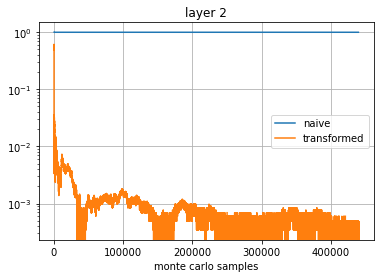

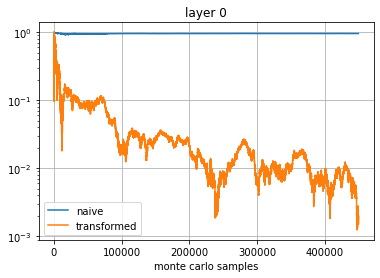

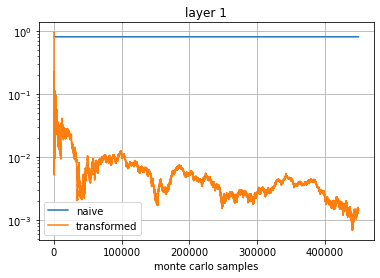

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


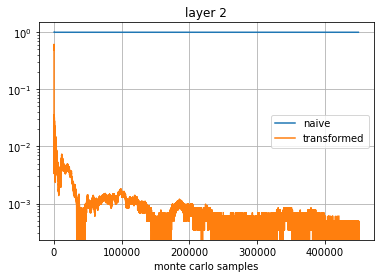

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


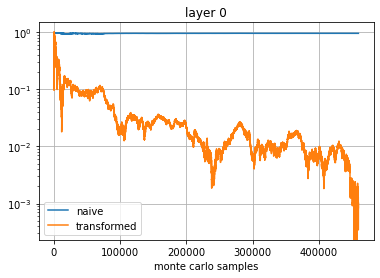

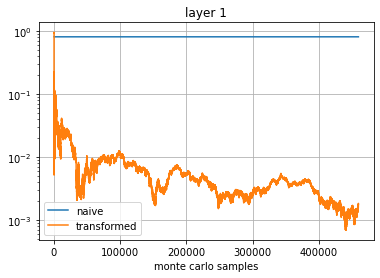

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


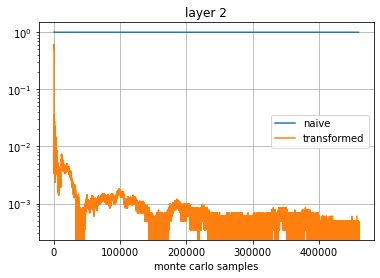

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


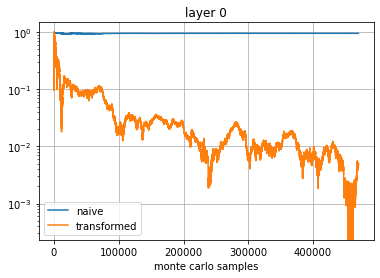

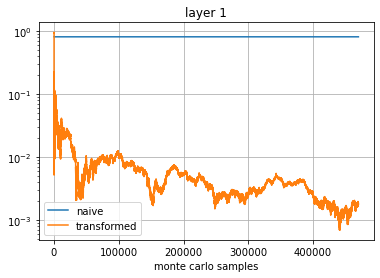

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


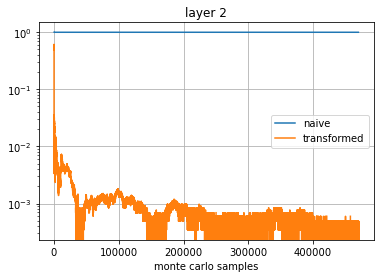

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


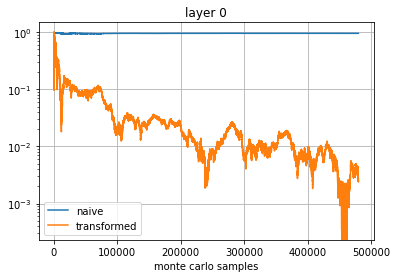

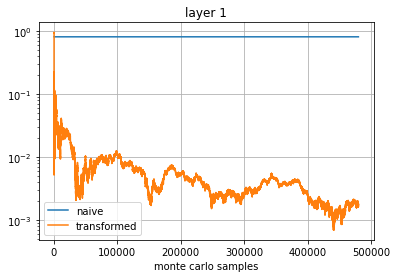

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


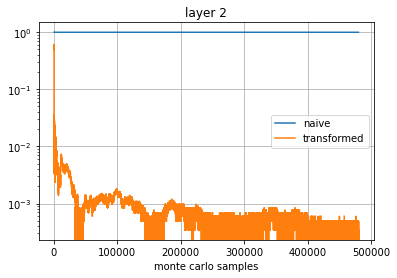

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


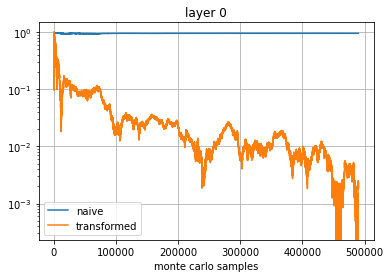

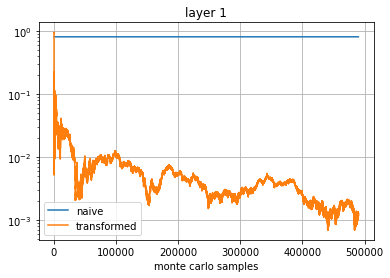

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


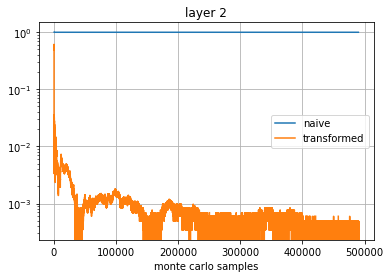

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


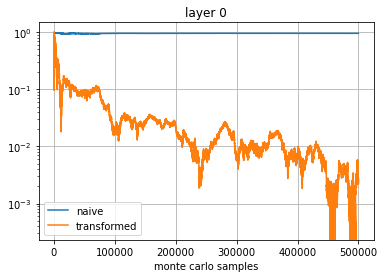

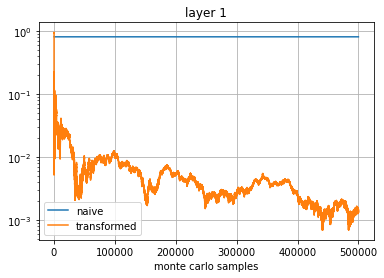

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


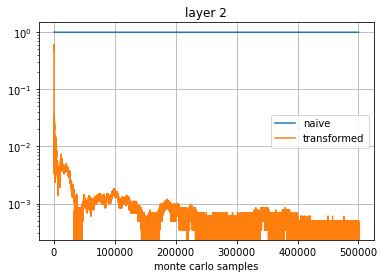

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


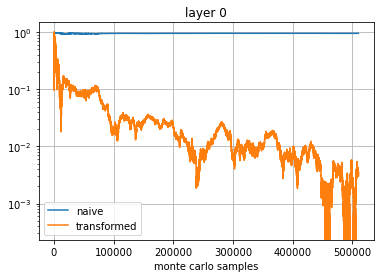

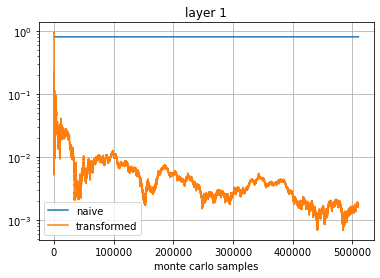

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


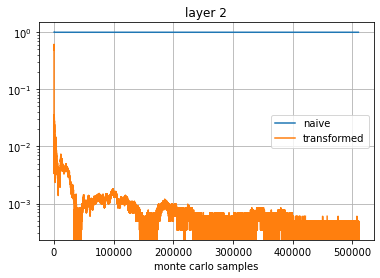

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


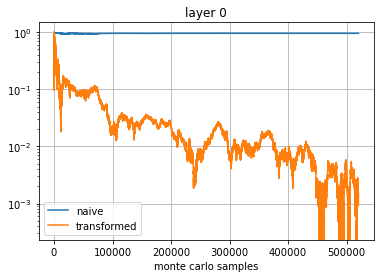

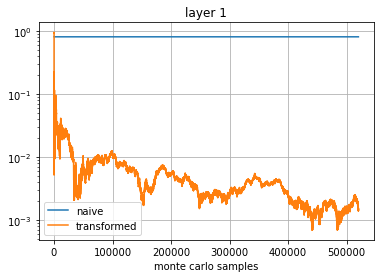

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


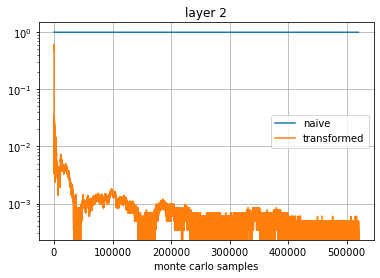

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


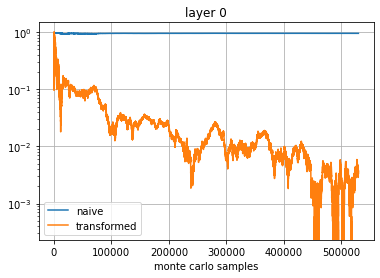

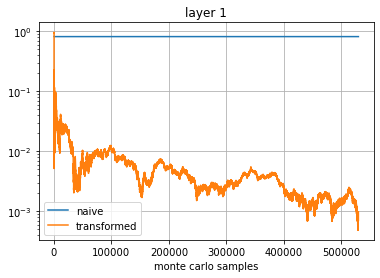

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


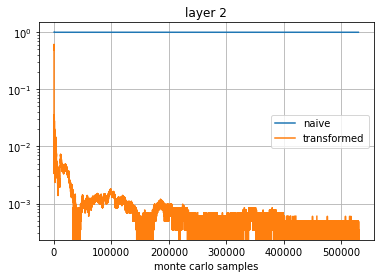

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


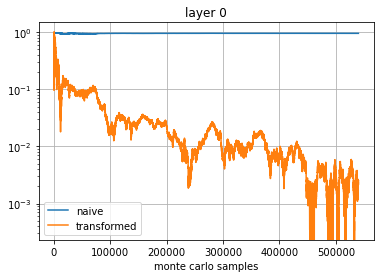

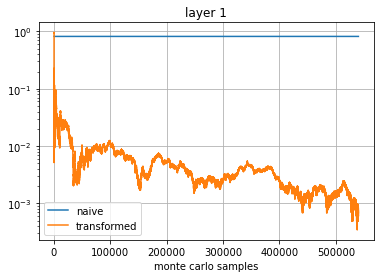

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


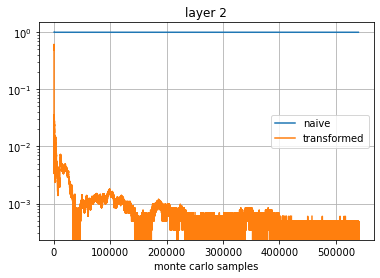

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


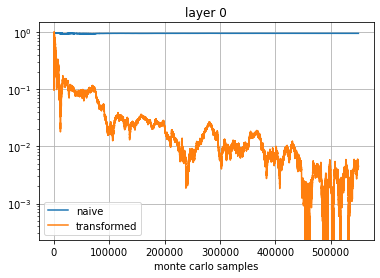

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


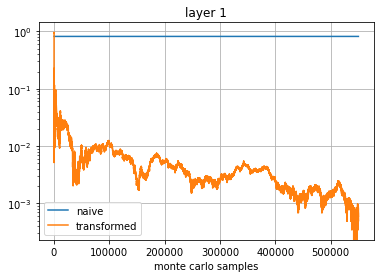

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


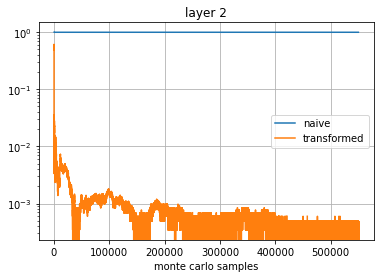

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


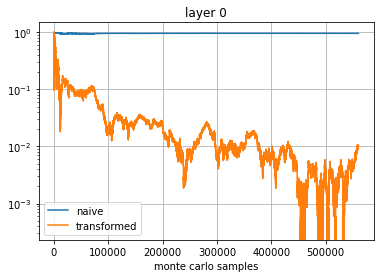

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


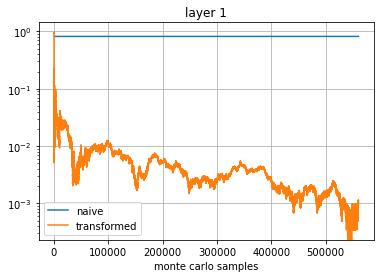

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


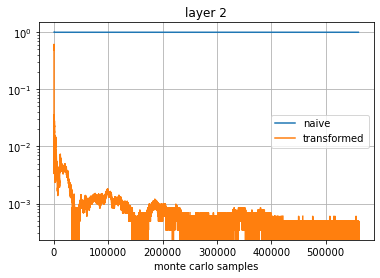

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


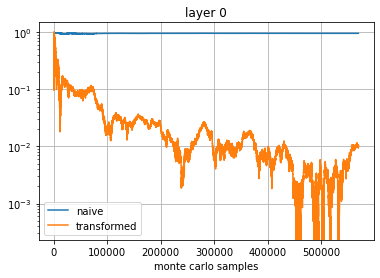

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


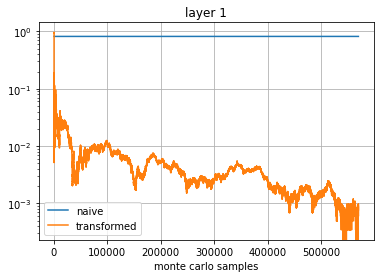

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


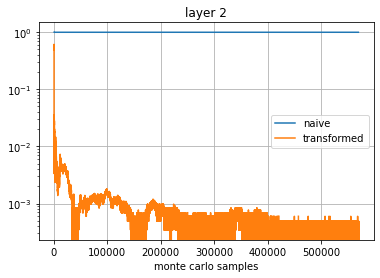

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


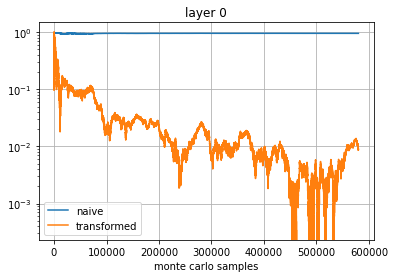

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


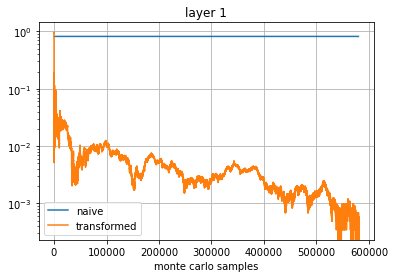

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


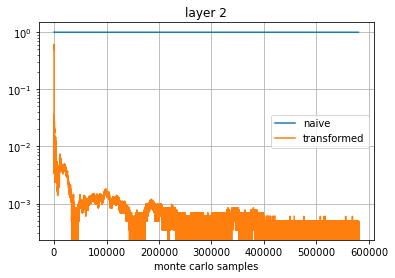

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


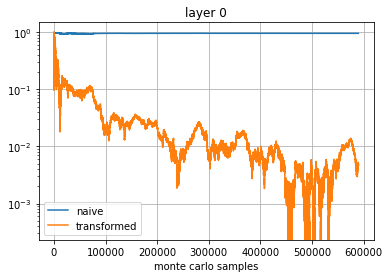

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


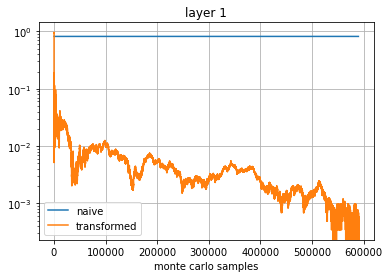

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


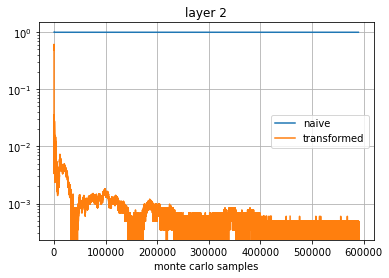

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


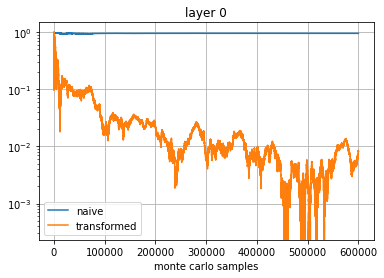

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


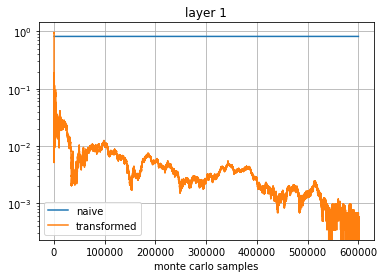

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


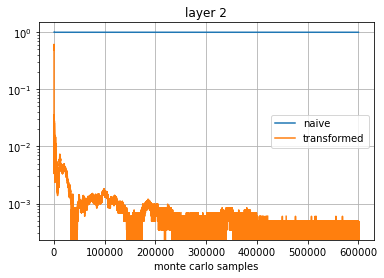

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


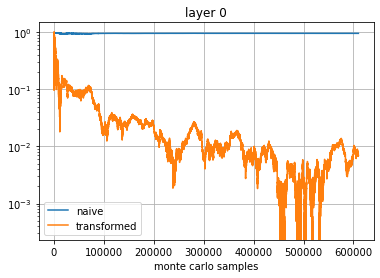

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


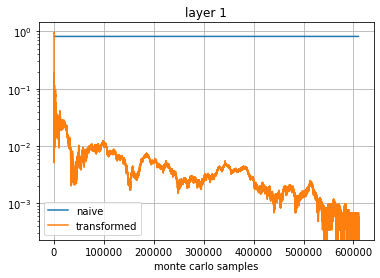

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


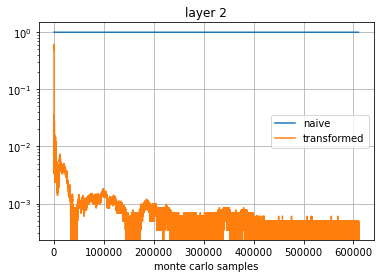

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


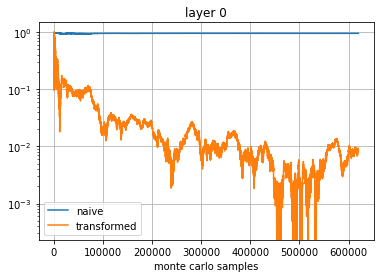

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


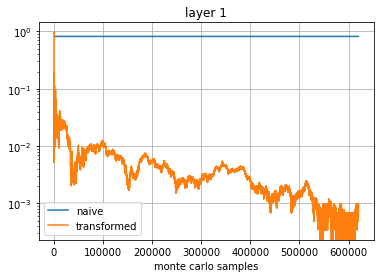

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


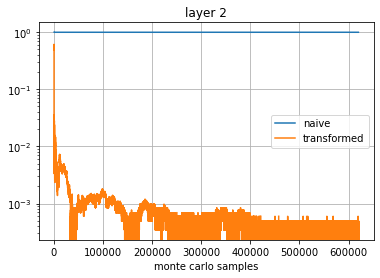

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


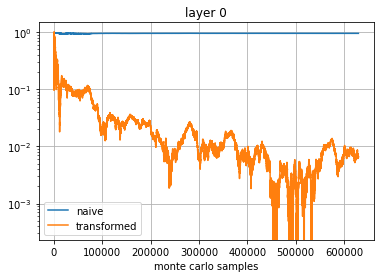

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


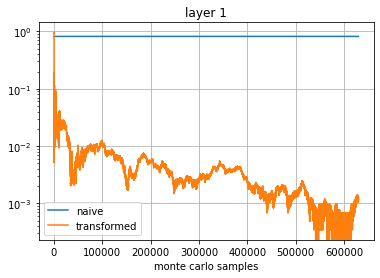

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


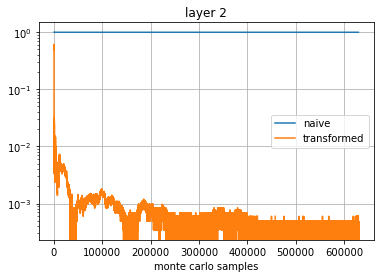

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


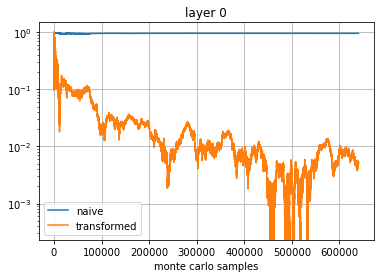

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


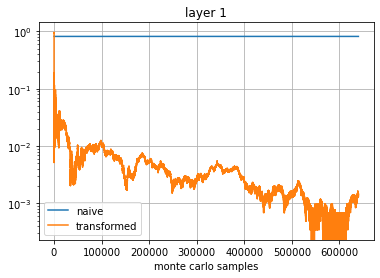

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


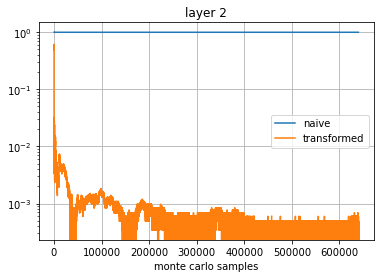

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


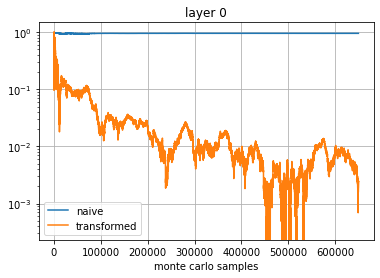

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


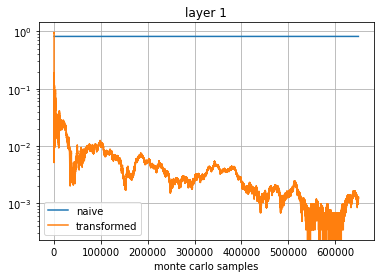

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


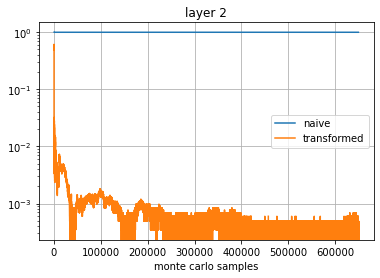

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


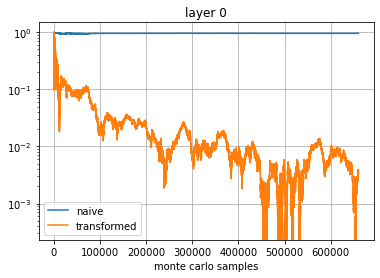

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


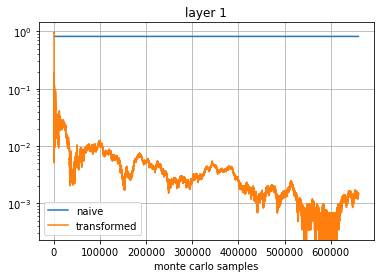

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


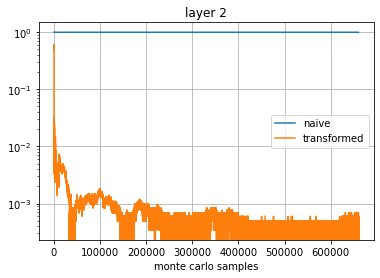

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


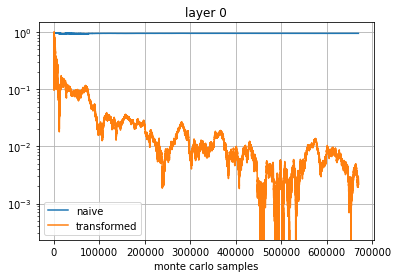

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


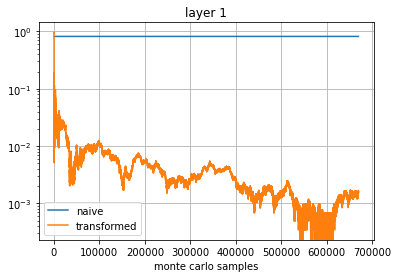

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


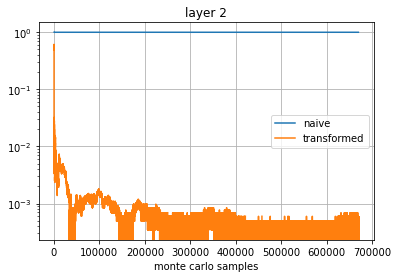

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


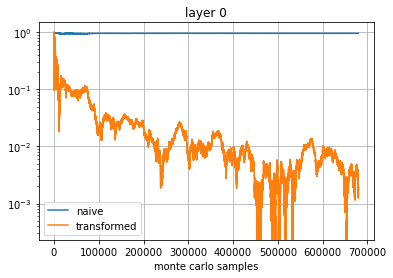

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


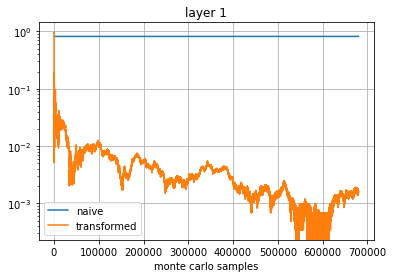

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


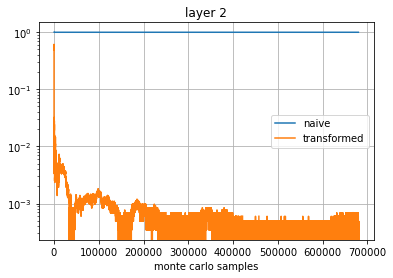

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


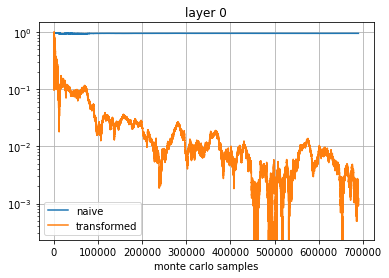

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


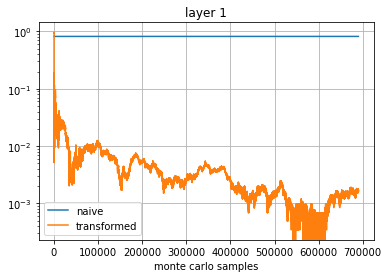

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


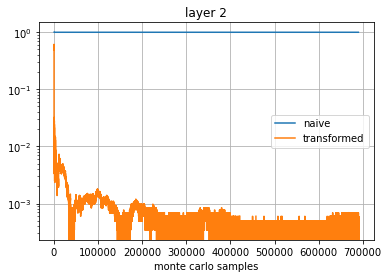

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


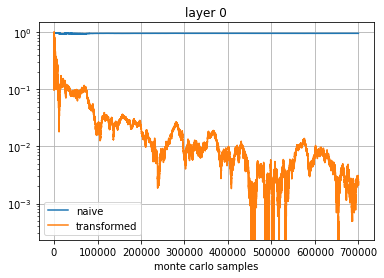

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


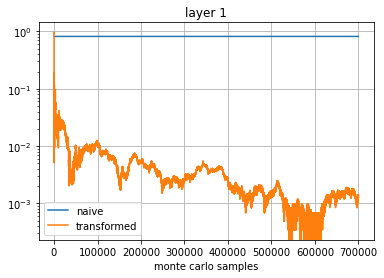

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


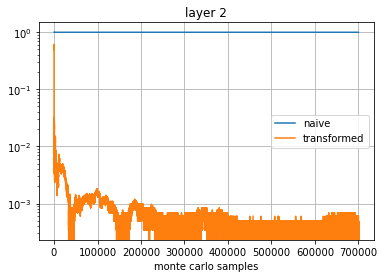

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


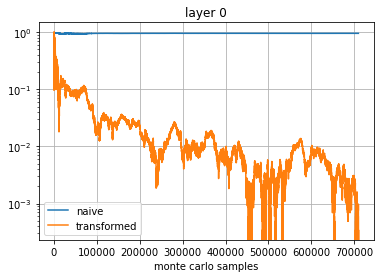

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


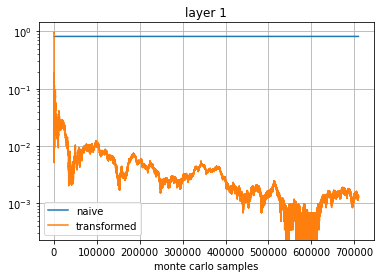

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


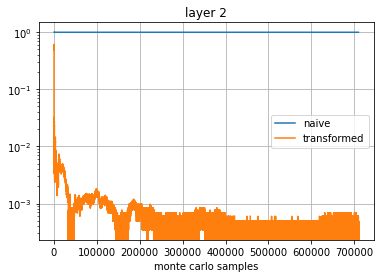

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


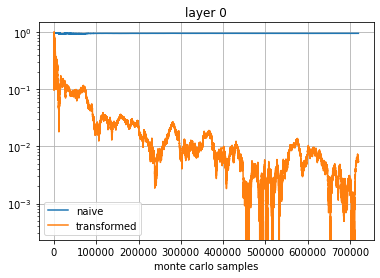

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


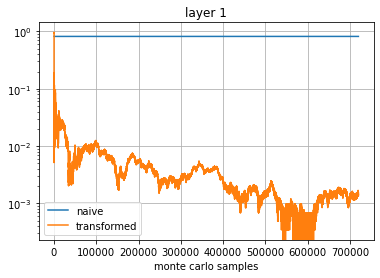

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


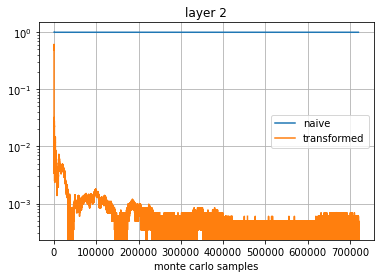

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


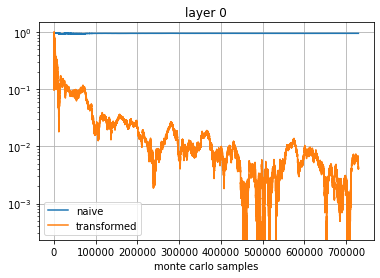

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


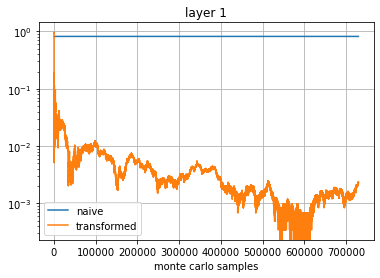

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


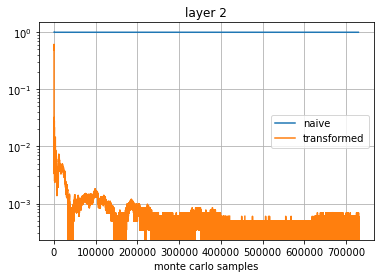

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


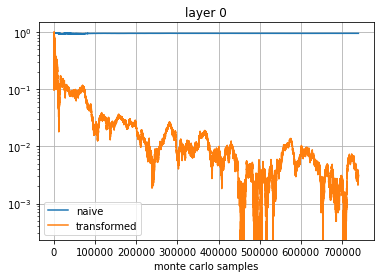

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


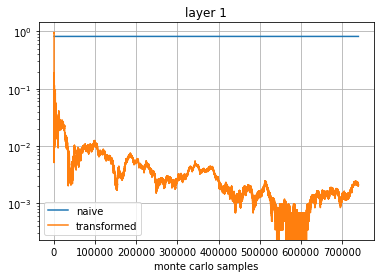

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


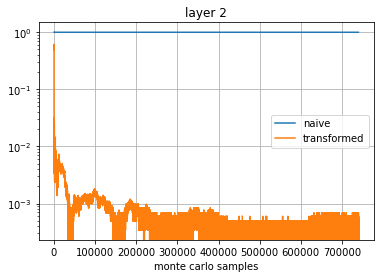

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


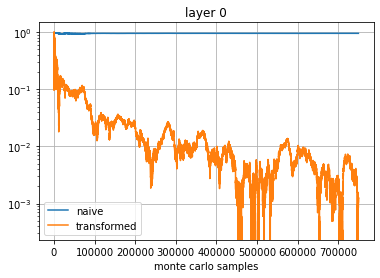

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


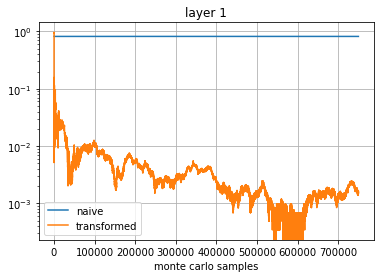

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


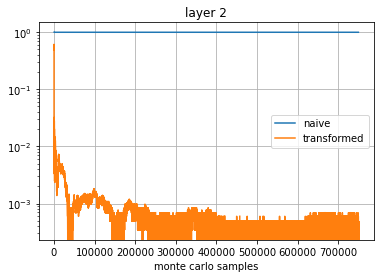

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


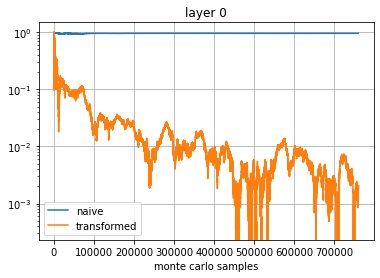

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


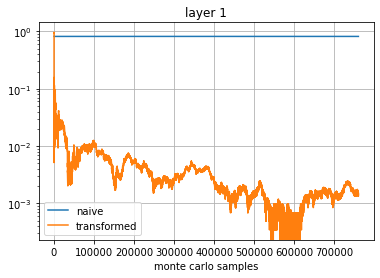

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


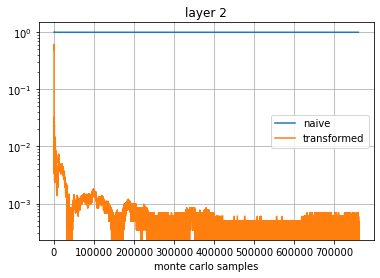

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


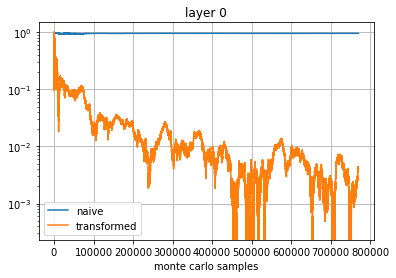

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


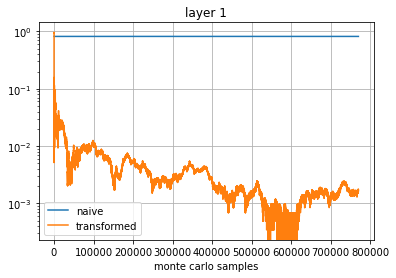

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


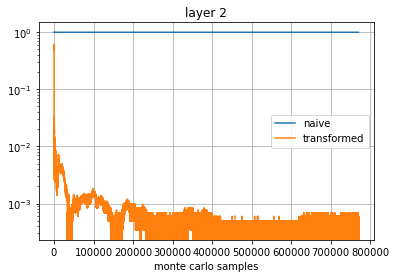

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


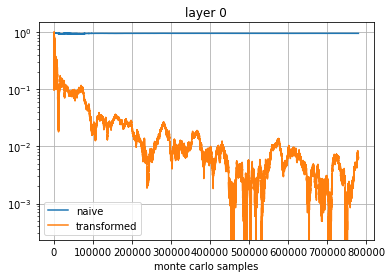

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


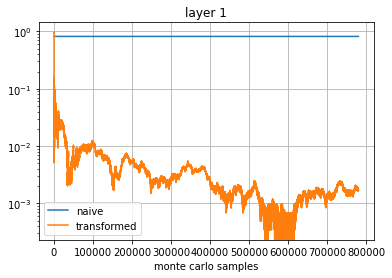

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


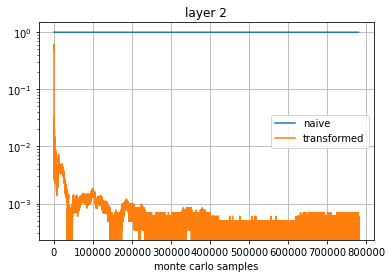

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


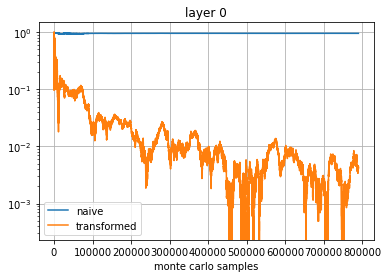

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


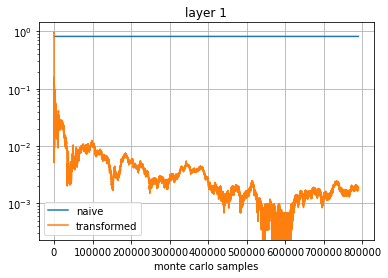

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


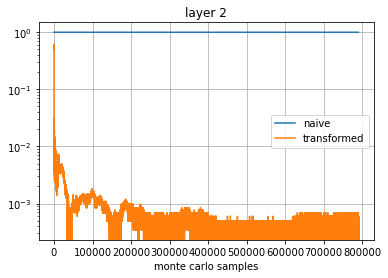

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


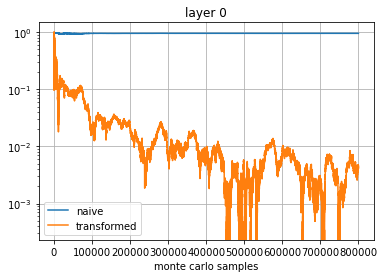

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


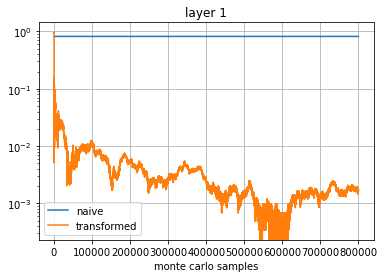

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


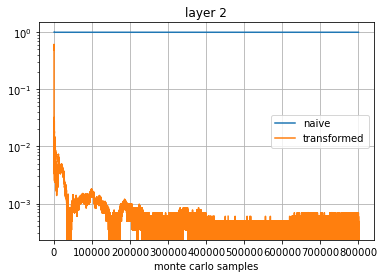

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


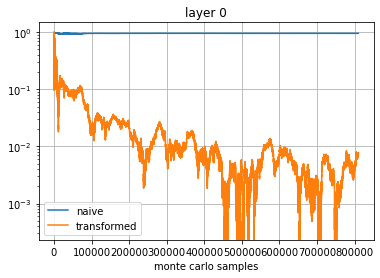

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


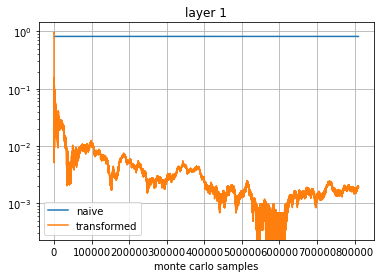

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


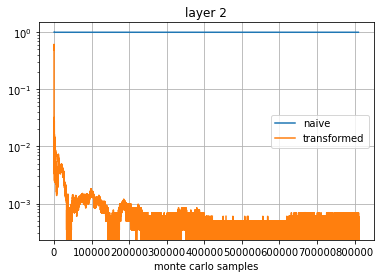

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


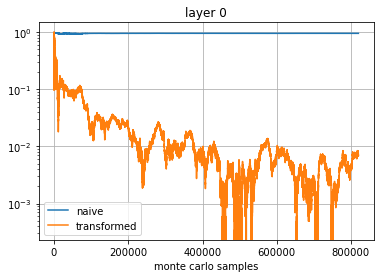

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


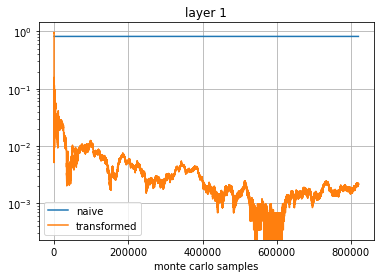

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


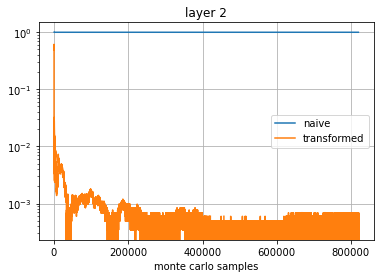

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


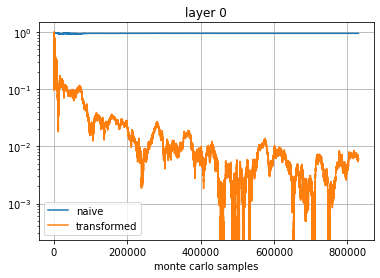

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


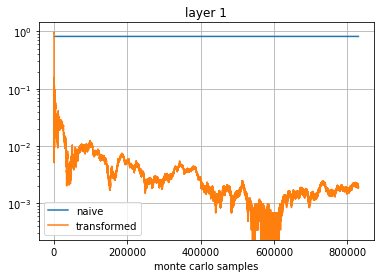

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


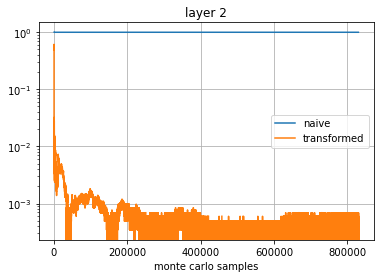

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


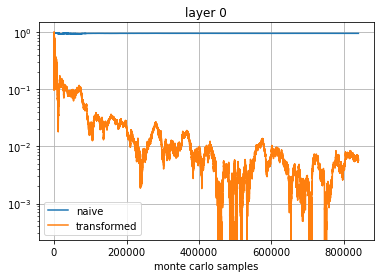

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


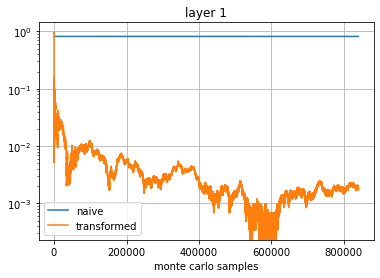

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


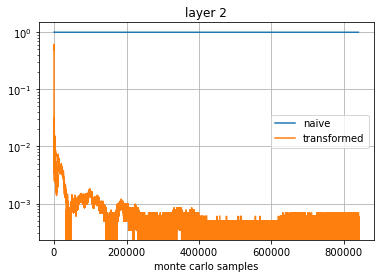

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


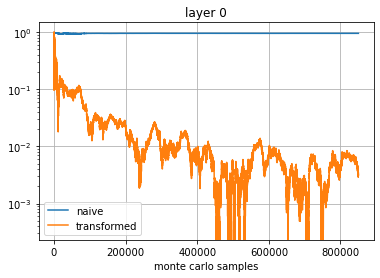

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


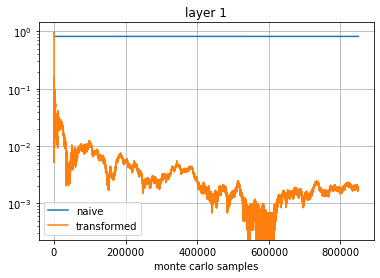

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


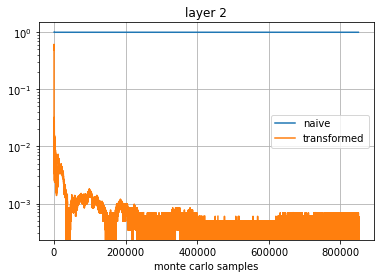

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


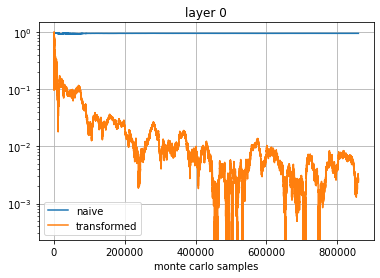

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


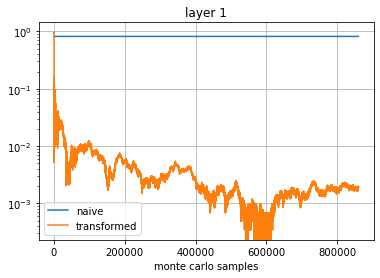

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


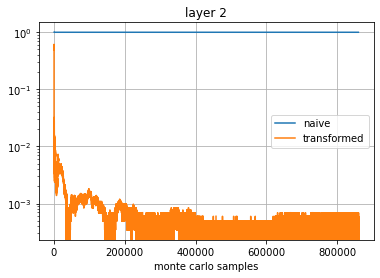

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


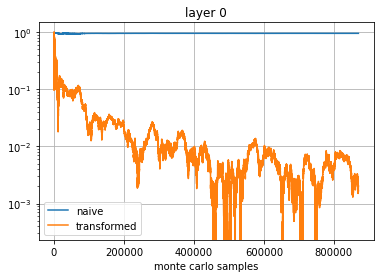

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


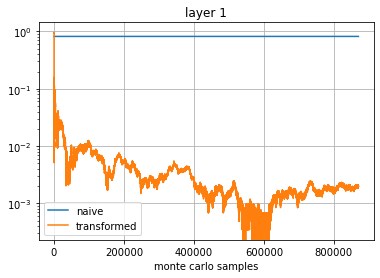

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


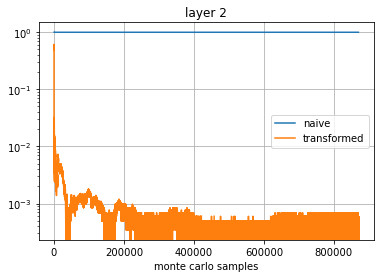

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


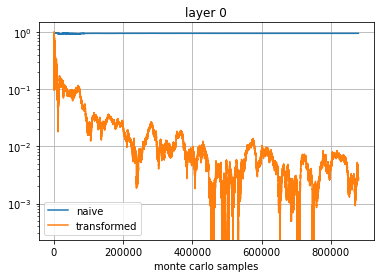

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


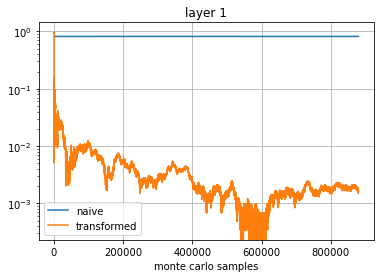

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


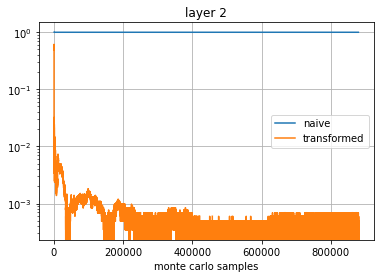

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


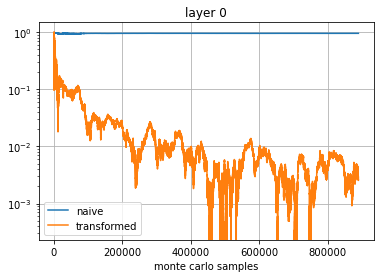

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


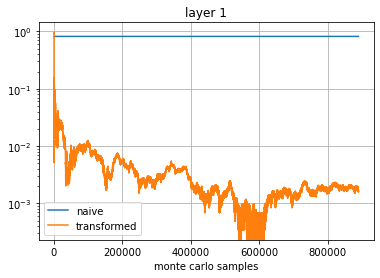

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


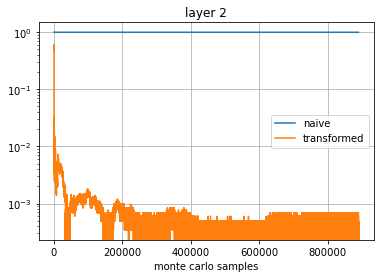

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


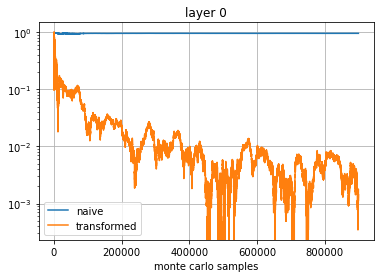

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


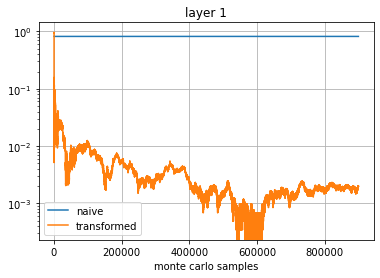

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


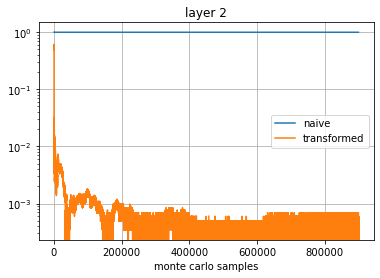

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


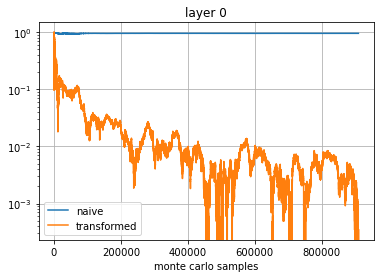

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


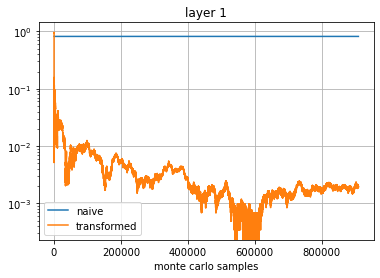

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


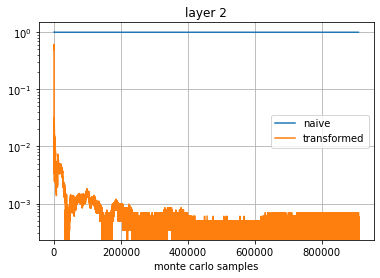

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


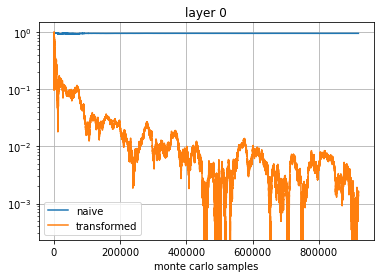

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


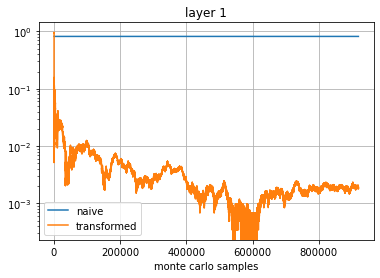

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


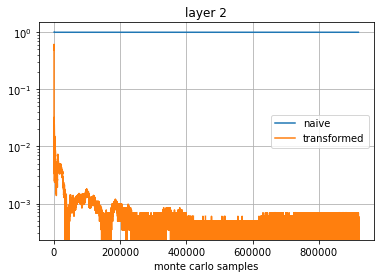

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


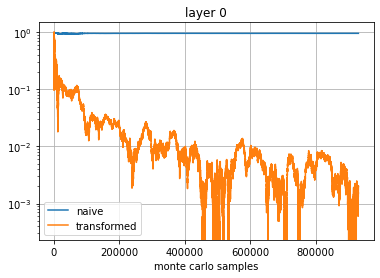

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


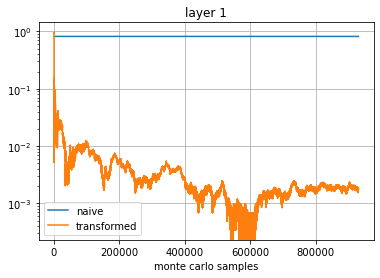

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


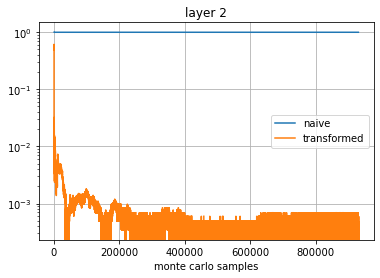

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


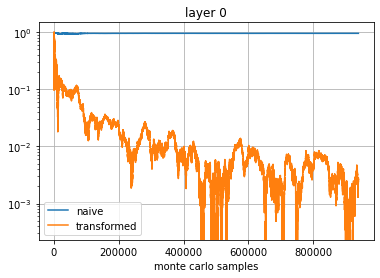

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


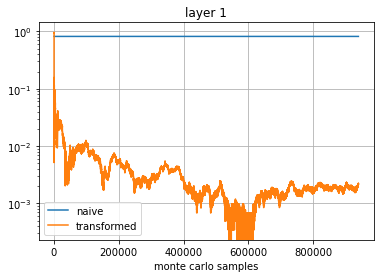

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


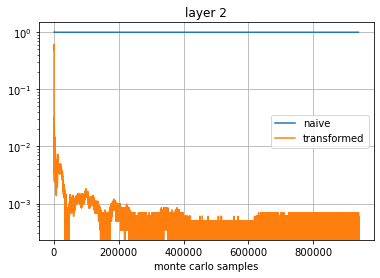

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


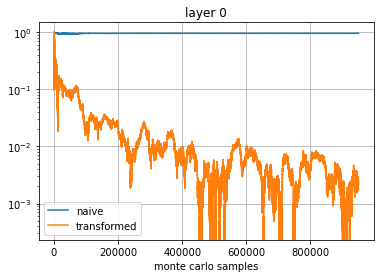

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


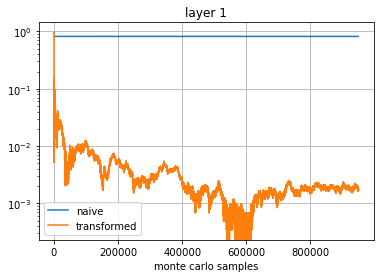

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


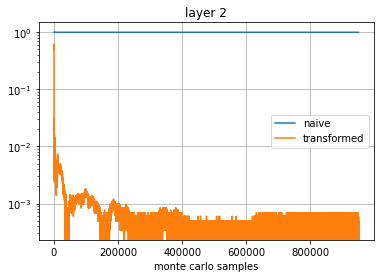

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


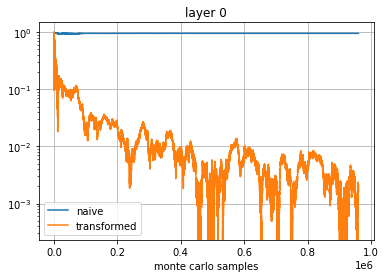

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


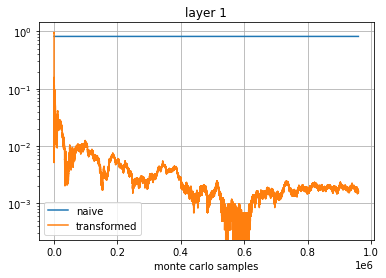

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


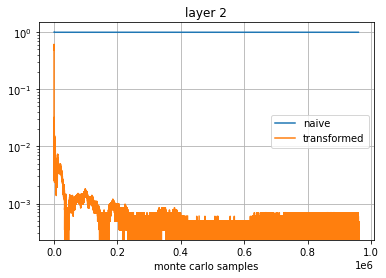

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


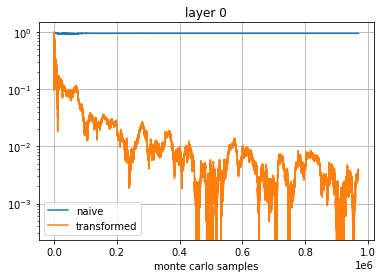

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


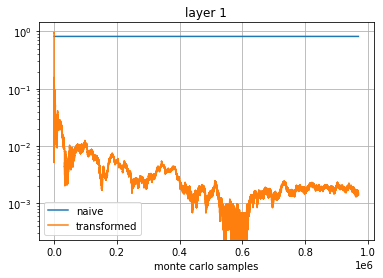

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


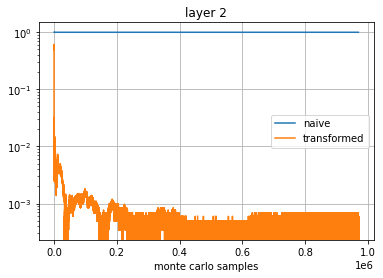

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


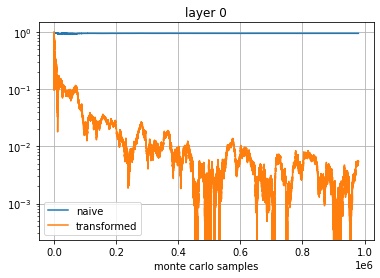

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


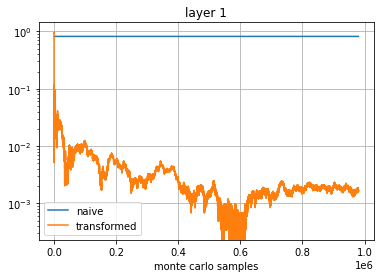

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


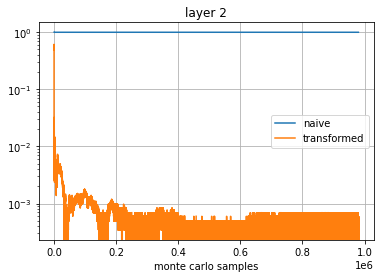

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


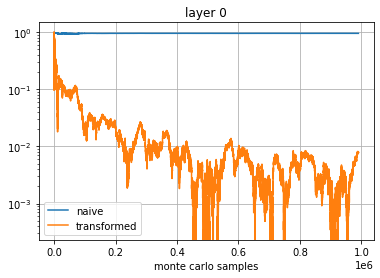

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


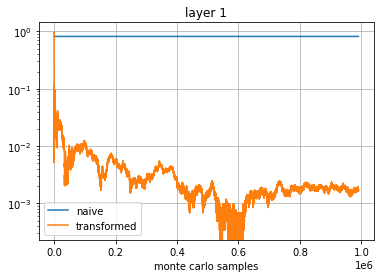

/home/yaniv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


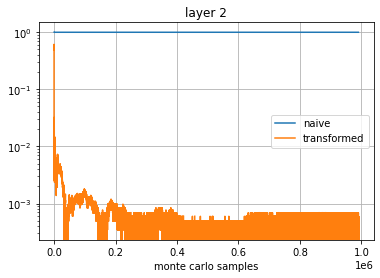

CPU times: user 1h 17min 45s, sys: 14 s, total: 1h 17min 59s
Wall time: 1h 17min 57s


In [7]:

    
def run_monte_carlo_EX(model, batch_size = 1, input_size = 16, batch_rep = 128,  N = 100, transform = False, track = True, use_b = True):
    
    
    model.zero_grad()
    X = torch.randn([batch_size,input_size],device = device).repeat(batch_rep,1)

    Js, Vs, Us, Qs, As, Abars = calc_all(model,device,X)

    y = torch.randn([batch_size,input_size],device = device).repeat(batch_rep,1)
    
    loss = ((model(X)-y)**2).sum()
    
    loss.backward()

    dLdout = 2*(model(X)-y)
    ##import pdb; pdb.set_trace()
    bwd_grad = Grad(model, grad = True)
    
    model.zero_grad()

    with torch.no_grad():
        real_grad = model.backward(dLdout, As)
    
    model.zero_grad()

    L = len(Js)-1
    avg_grad = Grad(model)
    avg_grad_transform = Grad(model)

    
    print("real vs bwd")
    print(np.arccos(real_grad.diff(bwd_grad)))
    
    assert(real_grad.normalize() -bwd_grad.normalize()  < 1e-3 )

    if track:
        avg_grad_track = np.zeros([N,model.layers+1])
        avg_grad_transform_track = np.zeros([N,model.layers+1])

    
    real_grad = real_grad.normalize()
    
    with torch.no_grad():
        for i in range(N):
            g0 = torch.randn_like(X)
            if use_b :
                b = (torch.rand([L]) > 0.5)*2 - 1
            else:
                b = torch.ones([L])

            x = X.clone()
            grad = model.mage_fb(X, g0, b, dLdout, Js, Vs, Us, Qs, As, Abars, transform = False)
            avg_grad+= grad

            x = X.clone()
            grad = model.mage_fb(X, g0, b, dLdout, Js, Vs, Us, Qs, As, Abars, transform = True)
            avg_grad_transform+= grad

            if track: 
                avg_grad_track[i,:] = np.asarray(real_grad.diff((avg_grad/(i+1)).normalize()))
                avg_grad_transform_track[i,:] = np.asarray(real_grad.diff((avg_grad_transform/(i+1)).normalize()))
                
                if i % 10000 == 0 and i > 0:
                    for j in range(model.layers+1):
                        plt.title("layer %d" % j)

                        plt.semilogy(range(i),np.sqrt(1-(avg_grad_track[:i,j])**2), label = "naive")
                        plt.semilogy(range(i),np.sqrt(1-(avg_grad_transform_track[:i,j])**2), label = "transformed")
                        plt.grid()
                        plt.legend()
                        plt.xlabel("monte carlo samples")
                        plt.show()
    
#             if track: 
#                 avg_grad_track[i,:] = np.asarray(real_grad.angle((avg_grad/(i+1)).normalize()))
#                 avg_grad_transform_track[i,:] = np.asarray(real_grad.angle((avg_grad_transform/(i+1)).normalize()))
                
            
#             if i % 10000 == 0 and i > 0:
#                 for j in range(model.layers+1):
#                     plt.title("layer %d" % j)
                    
#                     plt.plot(range(i),avg_grad_track[:i,j], label = "naive")
#                     plt.plot(range(i),avg_grad_transform_track[:i,j], label = "transformed")
#                     plt.grid()
#                     plt.legend()
#                     plt.xlabel("monte carlo samples")
#                     plt.show()
            
        avg_grad/= N
        avg_grad_transform/= N
        
        
    avg_grad = avg_grad.normalize()
    avg_grad_transform = avg_grad_transform.normalize()


    
    return real_grad, avg_grad, avg_grad_transform


N=1000000
    
##%time real_grad , avg_grad_fewshots , avg_gradT_fewshots  = run_monte_carlo_EX(model, batch_rep = 1024*16, N =N//10)
%time real_grad , avg_grad , avg_gradT = run_monte_carlo_EX(model, input_size = 4, batch_rep = 1024*16, N = N, use_b = True)

In [16]:
print("real vs naive")
print((real_grad.angle(avg_grad)))
print("real vs transformed")
print((real_grad.angle(avg_gradT)))
print("naive vs transformed")
print((avg_grad.angle(avg_gradT)))

print("naive vs lazy naive")
print((avg_grad.angle(avg_grad_fewshots)))
print("transformed vs lazy transformed")
print((avg_gradT.angle(avg_gradT_fewshots)))


real vs naive
[83.71612799478986, 75.78980498619214, 79.68484645208773]
real vs transformed
[29.84676656711301, 7.222407973810509, 9.012274398696356]
naive vs transformed
[74.53063358759172, 75.83379719444771, 79.28419693649258]
naive vs lazy naive
[79.92232801960843, 81.87287613076272, 82.54573148425365]
transformed vs lazy transformed
[87.50588641167998, 85.84868180682828, 93.54397501607276]


In [17]:
print("real vs naive")
print((real_grad.angle(avg_grad)))
print("real vs transformed")
print((real_grad.angle(avg_gradT)))
print("naive vs transformed")
print((avg_grad.angle(avg_gradT)))

print("naive vs lazy naive")
print((avg_grad.angle(avg_grad_fewshots)))
print("transformed vs lazy transformed")
print((avg_gradT.angle(avg_gradT_fewshots)))


real vs naive
[83.71612799478986, 75.78980498619214, 79.68484645208773]
real vs transformed
[29.84676656711301, 7.222407973810509, 9.012274398696356]
naive vs transformed
[74.53063358759172, 75.83379719444771, 79.28419693649258]
naive vs lazy naive
[79.92232801960843, 81.87287613076272, 82.54573148425365]
transformed vs lazy transformed
[87.50588641167998, 85.84868180682828, 93.54397501607276]


In [34]:
avg_grad.normalize()[0][0:3]

tensor([[ 0.0105,  0.0135,  0.0102, -0.0016, -0.0046, -0.0185, -0.0032, -0.0043,
         -0.0141,  0.0277,  0.0009,  0.0080, -0.0054,  0.0059, -0.0091,  0.0112],
        [ 0.1088,  0.1092,  0.0444, -0.1459, -0.1183, -0.1675, -0.0593, -0.0142,
         -0.1023,  0.3232, -0.0403,  0.0225, -0.0698,  0.1925,  0.0276,  0.0126],
        [ 0.0179,  0.0212, -0.0009, -0.0499, -0.0297, -0.0271, -0.0173, -0.0053,
         -0.0136,  0.0655, -0.0130, -0.0040, -0.0151,  0.0485,  0.0154, -0.0016]],
       device='cuda:3')

In [35]:
avg_grad_fewshots.normalize()[0][0:3]

tensor([[ 0.0066,  0.0145, -0.0137, -0.0084, -0.0162, -0.0158,  0.0139, -0.0186,
         -0.0146,  0.0038, -0.0215,  0.0090, -0.0031,  0.0065,  0.0022, -0.0084],
        [ 0.1173,  0.0743, -0.1541, -0.1404, -0.1807, -0.0679,  0.1456, -0.1255,
         -0.1840,  0.0812, -0.2077,  0.0493, -0.0378,  0.1025,  0.0727, -0.1183],
        [ 0.0219,  0.0075, -0.0336, -0.0324, -0.0370, -0.0013,  0.0260, -0.0268,
         -0.0390,  0.0200, -0.0456,  0.0020, -0.0091,  0.0276,  0.0202, -0.0264]],
       device='cuda:3')

In [56]:
torch.acos(torch.tensor(0.0))*180/np.pi

tensor(90.)